In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, glob, re
import numpy as np
import tqdm
import seaborn as sns
from prody import *

# Load and prepare data for clustering

In [4]:
df_ie_master = pd.read_excel('/opt/experiments/pep_hla_dynamics/data_compiled/df_ie_master_vdw.xlsx')

In [5]:
df_ie_master

,Unnamed: 0,IE,res1_index,res2_index,res1_chid,res2_chid,res1_resnum,res2_resnum,subtype,peptide
0,0,-1.914090,376,377,C,C,4,5,HLA_A_68_02,FVANFSMEL
1,1,-0.140101,65,377,A,C,66,5,HLA_A_68_02,FVANFSMEL
2,2,-0.299177,72,379,A,C,73,7,HLA_A_68_02,FVANFSMEL
3,3,-0.005925,99,373,A,C,100,1,HLA_A_68_02,FVANFSMEL
4,4,-0.955094,380,79,C,A,8,80,HLA_A_68_02,FVANFSMEL
...,...,...,...,...,...,...,...,...,...,...
693831,268,-0.291101,378,69,C,A,2,70,HLA_B_35_01,FPYTGDPPY
693832,269,-3.457709,379,158,C,A,3,159,HLA_B_35_01,FPYTGDPPY
693833,270,1.425141,378,4,C,A,2,5,HLA_B_35_01,FPYTGDPPY
693834,271,-0.029046,377,380,C,C,1,4,HLA_B_35_01,FPYTGDPPY


In [6]:
# Examine the data structure
print("Data shape:", df_ie_master.shape)
print("\nColumns:", df_ie_master.columns.tolist())
print("\nUnique subtypes:", df_ie_master['subtype'].nunique())
print("Unique peptides:", df_ie_master['peptide'].nunique())
print("\nChain ID combinations:")
print(df_ie_master.groupby(['res1_chid', 'res2_chid']).size())

Data shape: (693836, 10)

Columns: ['Unnamed: 0', 'IE', 'res1_index', 'res2_index', 'res1_chid', 'res2_chid', 'res1_resnum', 'res2_resnum', 'subtype', 'peptide']

Unique subtypes: 15
Unique peptides: 2087

Chain ID combinations:
res1_chid  res2_chid
A          C            341567
B          C                 9
C          A            290123
           B                17
           C             62120
dtype: int64


In [7]:
# Filter for peptide-HLA interactions (C chain = peptide, A chain = HLA)
# We want interactions where one chain is C (peptide) and the other is A (HLA)
peptide_hla_interactions = df_ie_master[
    ((df_ie_master['res1_chid'] == 'C') & (df_ie_master['res2_chid'] == 'A')) |
    ((df_ie_master['res1_chid'] == 'A') & (df_ie_master['res2_chid'] == 'C'))
].copy()

print(f"Filtered data shape: {peptide_hla_interactions.shape}")
print(f"Original data shape: {df_ie_master.shape}")
print(f"Percentage of peptide-HLA interactions: {100 * len(peptide_hla_interactions) / len(df_ie_master):.2f}%")

Filtered data shape: (631690, 10)
Original data shape: (693836, 10)
Percentage of peptide-HLA interactions: 91.04%


In [8]:
# Standardize the data so that we always have peptide residue info first, HLA residue info second
# This will make it easier to create consistent feature vectors

def standardize_interaction(row):
    """Ensure peptide residue info comes first, HLA residue info comes second"""
    if row['res1_chid'] == 'C':  # res1 is peptide
        return {
            'peptide_resnum': row['res1_resnum'],
            'hla_resnum': row['res2_resnum'],
            'peptide_index': row['res1_index'],
            'hla_index': row['res2_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }
    else:  # res2 is peptide
        return {
            'peptide_resnum': row['res2_resnum'],
            'hla_resnum': row['res1_resnum'],
            'peptide_index': row['res2_index'],
            'hla_index': row['res1_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }

# Apply standardization
standardized_data = []
for _, row in tqdm.tqdm(peptide_hla_interactions.iterrows(), total=len(peptide_hla_interactions), desc="Standardizing interactions"):
    standardized_data.append(standardize_interaction(row))

df_standardized = pd.DataFrame(standardized_data)
print(f"Standardized data shape: {df_standardized.shape}")
df_standardized.head()

Standardizing interactions:   0%|          | 1763/631690 [00:00<00:35, 17628.63it/s]

Standardizing interactions: 100%|██████████| 631690/631690 [00:15<00:00, 40771.94it/s]


Standardized data shape: (631690, 7)


,peptide_resnum,hla_resnum,peptide_index,hla_index,IE,subtype,peptide
0,5,66,377,65,-0.140101,HLA_A_68_02,FVANFSMEL
1,7,73,379,72,-0.299177,HLA_A_68_02,FVANFSMEL
2,1,100,373,99,-0.005925,HLA_A_68_02,FVANFSMEL
3,8,80,380,79,-0.955094,HLA_A_68_02,FVANFSMEL
4,8,72,380,71,-0.008256,HLA_A_68_02,FVANFSMEL


In [9]:
# Create feature vectors for each peptide-subtype combination
# Each vector will contain IE values for all peptide-HLA residue interactions

def create_feature_vector(group):
    """Create a feature vector for a peptide-subtype combination"""
    # Sort by peptide residue number and HLA residue number for consistency
    group_sorted = group.sort_values(['peptide_resnum', 'hla_resnum'])
    
    # Create a unique identifier for each peptide-HLA residue pair
    group_sorted['interaction_id'] = (group_sorted['peptide_resnum'].astype(str) + '_' + 
                                     group_sorted['hla_resnum'].astype(str))
    
    # Return the IE values as a series with interaction IDs as index
    return pd.Series(group_sorted['IE'].values, index=group_sorted['interaction_id'])

print("Creating feature vectors for each peptide-subtype combination...")
feature_vectors = df_standardized.groupby(['peptide', 'subtype']).apply(create_feature_vector)

print(f"Feature vectors shape: {feature_vectors.shape}")
print(f"Number of unique peptide-subtype combinations: {len(feature_vectors)}")

# Convert to DataFrame where each row is a peptide-subtype combination
# and each column is a peptide-HLA residue interaction
clustering_matrix = feature_vectors.unstack(level=-1)
print(f"Clustering matrix shape: {clustering_matrix.shape}")

# Fill NaN values with 0 (interactions that don't exist)
clustering_matrix = clustering_matrix.fillna(0)

print(f"Final clustering matrix shape: {clustering_matrix.shape}")
print(f"Number of features (peptide-HLA interactions): {clustering_matrix.shape[1]}")
print(f"Number of samples (peptide-subtype combinations): {clustering_matrix.shape[0]}")

clustering_matrix.head()

Creating feature vectors for each peptide-subtype combination...
Feature vectors shape: (631690,)
Number of unique peptide-subtype combinations: 631690
Clustering matrix shape: (2605, 780)
Final clustering matrix shape: (2605, 780)
Number of features (peptide-HLA interactions): 780
Number of samples (peptide-subtype combinations): 2605


/tmp/ipykernel_3568668/2845629192.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_vectors = df_standardized.groupby(['peptide', 'subtype']).apply(create_feature_vector)


,interaction_id,1_10,1_100,1_101,1_102,1_11,1_113,1_114,1_154,1_155,1_156,...,9_86,9_87,9_9,9_93,9_94,9_95,9_96,9_97,9_98,9_99
peptide,subtype,,,,,,,,,,,,,,,,,,,,,
AAAAFEAAL,HLA_C_14_02,0.0,-0.005831,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,-0.464258,-0.045878,-1.436696,0.000000,0.0,0.0
AAAANTTAL,HLA_C_03_03,0.0,-0.003669,-0.003392,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,-0.004387,0.0,0.000000,-1.559280,-0.062136,-0.115756,0.0,0.0
AAAQGQAPL,HLA_C_14_02,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-0.015665,0.0,...,0.0,0.0,0.000000,0.0,-0.672877,-0.054027,-1.061489,0.000000,0.0,0.0
AAAVAYPEL,HLA_C_03_03,0.0,-0.004976,-0.003273,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,-0.112068,-0.052490,-0.078330,0.0,0.0
AAAWYLWEV,HLA_A_02_01,0.0,-0.008443,-0.010076,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,-0.065273,0.000000,-0.314170,0.0,0.0


In [16]:
# Filter to include only interactions of peptide residues 2 and 9
clustering_matrix_filtered = clustering_matrix.filter(regex='^(2_|9_)', axis=1)
print(f"Filtered clustering matrix shape (residues 2 and 9 only): {clustering_matrix_filtered.shape}")
clustering_matrix_filtered.head()

Filtered clustering matrix shape (residues 2 and 9 only): (2605, 150)


,interaction_id,2_10,2_100,2_101,2_102,2_113,2_114,2_115,2_154,2_155,2_156,...,9_86,9_87,9_9,9_93,9_94,9_95,9_96,9_97,9_98,9_99
peptide,subtype,,,,,,,,,,,,,,,,,,,,,
AAAAFEAAL,HLA_C_14_02,0.0,-0.001209,0.000000,0.0,-0.002471,0.0,0.0,0.0,-0.013744,0.000000,...,0.0,0.0,0.000000,0.0,-0.464258,-0.045878,-1.436696,0.000000,0.0,0.0
AAAANTTAL,HLA_C_03_03,0.0,-0.005247,-0.000438,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.002662,...,0.0,0.0,-0.004387,0.0,0.000000,-1.559280,-0.062136,-0.115756,0.0,0.0
AAAQGQAPL,HLA_C_14_02,0.0,-0.002488,0.000000,0.0,0.000000,0.0,0.0,0.0,-0.024707,0.000000,...,0.0,0.0,0.000000,0.0,-0.672877,-0.054027,-1.061489,0.000000,0.0,0.0
AAAVAYPEL,HLA_C_03_03,0.0,-0.005464,-0.000376,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.004106,...,0.0,0.0,0.000000,0.0,0.000000,-0.112068,-0.052490,-0.078330,0.0,0.0
AAAWYLWEV,HLA_A_02_01,0.0,-0.002506,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,-0.065273,0.000000,-0.314170,0.0,0.0


In [38]:
# Filter to exclude weak interactions, e.g. those with |IE| > 1.4 only for maximum 20 peptide-subtype pairs
# This step is optional and can be adjusted based on the analysis needs
interaction_strength = (clustering_matrix_filtered.abs() > 1.4).sum(axis=0)
weak_interactions = interaction_strength[interaction_strength <= 20].index
# Exclude weak interactions
clustering_matrix_filtered_weak = clustering_matrix_filtered.drop(columns=weak_interactions)
print(f"Clustering matrix shape after filtering weak interactions: {clustering_matrix_filtered_weak.shape}")

Clustering matrix shape after filtering weak interactions: (2605, 53)


In [10]:
# Import clustering libraries
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Hierarchical clustering (seaborn clustermap)

Performing hierarchical clustering using seaborn clustermap...


/home/onur/anaconda3/envs/datascience/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/onur/anaconda3/envs/datascience/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


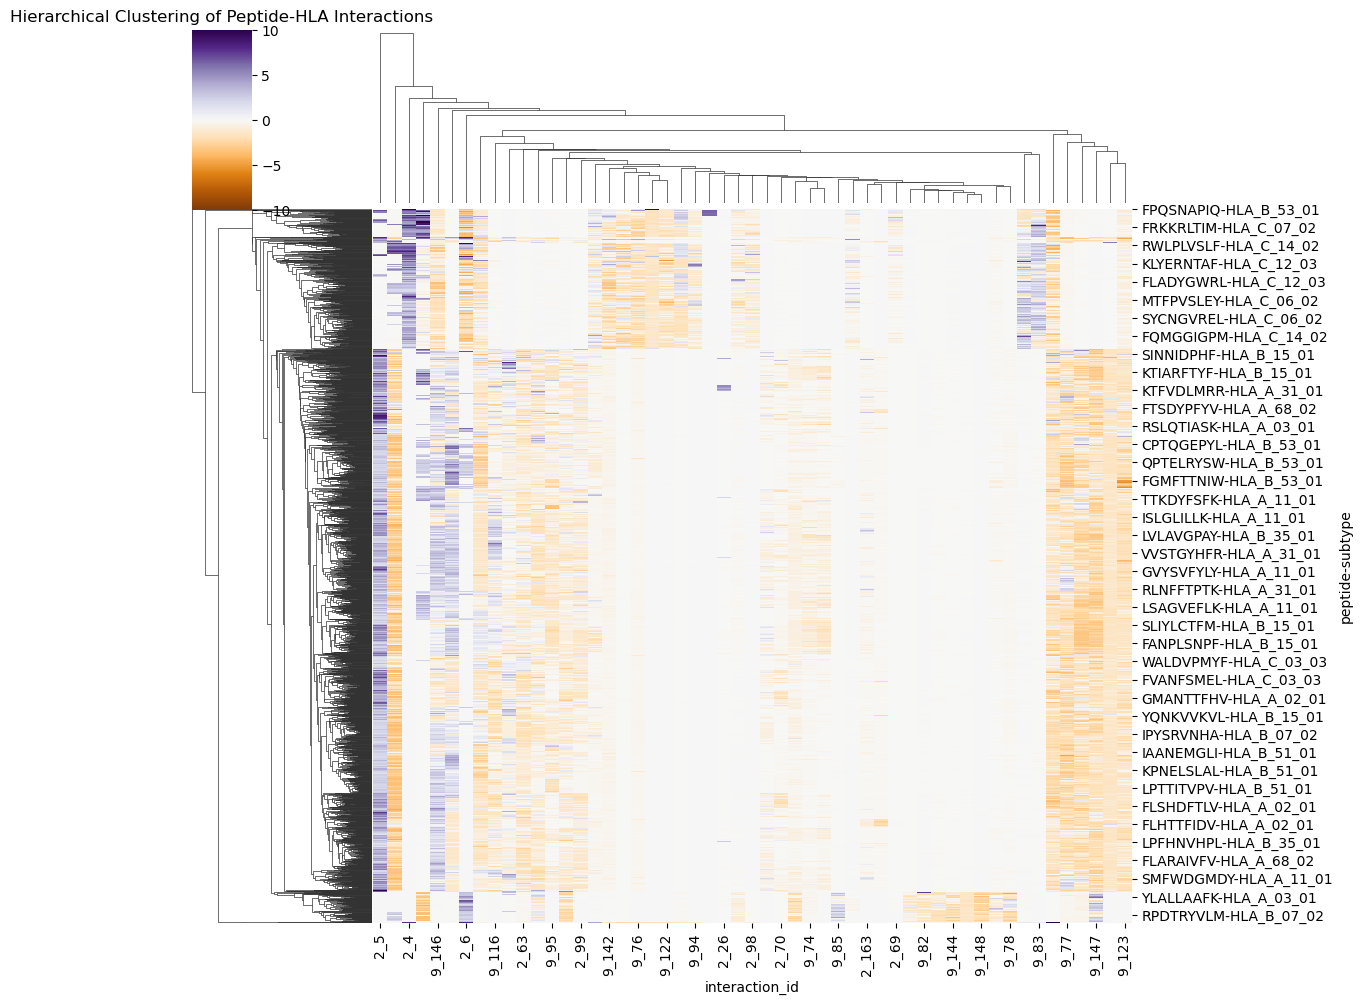

In [39]:
# Hierarchical clustering using seaborn clustermap
print("Performing hierarchical clustering using seaborn clustermap...")
# Create a clustermap
clustermap = sns.clustermap(clustering_matrix_filtered_weak, method='average', metric='euclidean', cmap='PuOr', vmin=-10, vmax=10, figsize=(12, 10))
plt.title('Hierarchical Clustering of Peptide-HLA Interactions')
plt.show()

# k-means clustering

In [ ]:
# Import k-means clustering library
from sklearn.cluster import KMeans

# DBSCAN Clustering

In [ ]:
# Import DBSCAN clustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

print("Setting up DBSCAN clustering analysis...")
print("Requirement: Minimum 40 samples per cluster")
print(f"Total samples available: {X_scaled.shape[0]}")
print(f"Total features: {X_scaled.shape[1]}")

Setting up DBSCAN clustering analysis...
Requirement: Minimum 40 samples per cluster
Total samples available: 2605
Total features: 780


In [16]:
# Step 2: Optimize DBSCAN parameters to minimize noise
print("\nStep 2: Optimizing DBSCAN parameters to minimize noise...")

min_samples_requirement = 10  # New requirement: min 10 samples per cluster

# Determine eps range using k-distance
k = min_samples_requirement
neighbors_simple = NearestNeighbors(n_neighbors=k)
neighbors_fit_simple = neighbors_simple.fit(X_residues_2_9_scaled)
distances_simple, indices_simple = neighbors_fit_simple.kneighbors(X_residues_2_9_scaled)

# Sort distances to k-th nearest neighbor
distances_sorted_simple = np.sort(distances_simple[:, k-1], axis=0)[::-1]

# Find elbow point
gradient_simple = np.gradient(distances_sorted_simple)
elbow_idx_simple = np.argmax(gradient_simple[50:]) + 50  # Skip first 50 to avoid noise
optimal_eps_simple = distances_sorted_simple[elbow_idx_simple]

print(f"Suggested eps from k-distance: {optimal_eps_simple:.4f}")

# Test a comprehensive range of eps values to minimize noise
eps_test_range = np.linspace(optimal_eps_simple * 0.3, optimal_eps_simple * 2.0, 30)
min_samples_test = [8, 10, 12, 15]  # Test around the requirement

print(f"Testing {len(eps_test_range)} eps values × {len(min_samples_test)} min_samples values...")

best_results = []

for eps_test in eps_test_range:
    for min_samples_test_val in min_samples_test:
        # Run DBSCAN
        dbscan_test = DBSCAN(eps=eps_test, min_samples=min_samples_test_val)
        labels_test = dbscan_test.fit_predict(X_residues_2_9_scaled)
        
        # Calculate metrics
        n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise_test = list(labels_test).count(-1)
        n_clustered_test = len(labels_test) - n_noise_test
        
        # Calculate cluster sizes
        cluster_sizes_test = []
        if n_clusters_test > 0:
            unique_labels_test = set(labels_test)
            for label in unique_labels_test:
                if label != -1:  # Exclude noise
                    cluster_size = list(labels_test).count(label)
                    cluster_sizes_test.append(cluster_size)
        
        # Check if all clusters meet minimum size requirement
        min_cluster_size_test = min(cluster_sizes_test) if cluster_sizes_test else 0
        meets_requirement_test = min_cluster_size_test >= min_samples_requirement
        
        # Calculate score prioritizing: 1) meets requirement, 2) low noise, 3) reasonable number of clusters
        if meets_requirement_test and n_clusters_test > 0:
            # Score: maximize clustered samples, minimize noise, moderate number of clusters
            noise_penalty = (n_noise_test / len(labels_test)) * 100
            cluster_bonus = min(n_clusters_test * 5, 25)  # Cap cluster bonus at 25
            score = n_clustered_test - noise_penalty + cluster_bonus
        else:
            score = -1000  # Heavily penalize if requirement not met
        
        best_results.append({
            'eps': eps_test,
            'min_samples': min_samples_test_val,
            'n_clusters': n_clusters_test,
            'n_noise': n_noise_test,
            'n_clustered': n_clustered_test,
            'noise_pct': (n_noise_test / len(labels_test)) * 100,
            'cluster_sizes': cluster_sizes_test,
            'min_cluster_size': min_cluster_size_test,
            'meets_requirement': meets_requirement_test,
            'score': score,
            'labels': labels_test.copy()
        })

# Convert to DataFrame and analyze
results_simple_df = pd.DataFrame(best_results)

# Filter valid results (meet requirement)
valid_results_simple = results_simple_df[results_simple_df['meets_requirement'] == True].copy()

if len(valid_results_simple) > 0:
    # Sort by score (highest first) - this prioritizes low noise
    valid_results_simple = valid_results_simple.sort_values('score', ascending=False)
    
    print(f"\n✅ Found {len(valid_results_simple)} valid parameter combinations!")
    print("\nTop 5 results (optimized for low noise):")
    top_5 = valid_results_simple.head()[['eps', 'min_samples', 'n_clusters', 'n_clustered', 'n_noise', 'noise_pct', 'min_cluster_size']]
    for _, row in top_5.iterrows():
        print(f"  eps={row['eps']:.3f}, min_samples={int(row['min_samples'])}: "
              f"{int(row['n_clusters'])} clusters, {int(row['n_clustered'])} clustered, "
              f"{int(row['n_noise'])} noise ({row['noise_pct']:.1f}%)")
    
    # Select best parameters
    best_row = valid_results_simple.iloc[0]
    best_eps_simple = best_row['eps']
    best_min_samples_simple = best_row['min_samples']
    best_labels_simple = best_row['labels']
    
    print(f"\n🎯 Selected parameters:")
    print(f"   eps: {best_eps_simple:.4f}")
    print(f"   min_samples: {int(best_min_samples_simple)}")
    print(f"   Clusters: {int(best_row['n_clusters'])}")
    print(f"   Clustered samples: {int(best_row['n_clustered'])}")
    print(f"   Noise points: {int(best_row['n_noise'])} ({best_row['noise_pct']:.1f}%)")
    
else:
    print("⚠️  No valid results found! Showing best available:")
    best_available = results_simple_df.loc[results_simple_df['score'].idxmax()]
    print(f"Best available: eps={best_available['eps']:.3f}, min_samples={int(best_available['min_samples'])}")
    print(f"Clusters: {int(best_available['n_clusters'])}, Min cluster size: {int(best_available['min_cluster_size'])}")
    
    best_eps_simple = best_available['eps']
    best_min_samples_simple = best_available['min_samples']
    best_labels_simple = best_available['labels']


Step 2: Optimizing DBSCAN parameters to minimize noise...
Suggested eps from k-distance: 3.8024
Testing 30 eps values × 4 min_samples values...

✅ Found 94 valid parameter combinations!

Top 5 results (optimized for low noise):
  eps=7.605, min_samples=8: 3 clusters, 2155 clustered, 450 noise (17.3%)
  eps=7.605, min_samples=10: 3 clusters, 2143 clustered, 462 noise (17.7%)
  eps=7.382, min_samples=8: 3 clusters, 2127 clustered, 478 noise (18.3%)
  eps=7.605, min_samples=12: 2 clusters, 2120 clustered, 485 noise (18.6%)
  eps=7.605, min_samples=15: 2 clusters, 2107 clustered, 498 noise (19.1%)

🎯 Selected parameters:
   eps: 7.6049
   min_samples: 8
   Clusters: 3
   Clustered samples: 2155
   Noise points: 450 (17.3%)


In [ ]:
# Step 3: Final clustering and heatmap generation
print("\nStep 3: Final clustering and analysis...")

# Run final DBSCAN with selected parameters
dbscan_final_simple = DBSCAN(eps=best_eps_simple, min_samples=int(best_min_samples_simple))
final_labels_simple = dbscan_final_simple.fit_predict(X_residues_2_9_scaled)

# Analyze final results
unique_labels_simple = set(final_labels_simple)
n_clusters_final_simple = len(unique_labels_simple) - (1 if -1 in unique_labels_simple else 0)
n_noise_final_simple = list(final_labels_simple).count(-1)
n_clustered_final_simple = len(final_labels_simple) - n_noise_final_simple

print(f"\n✅ FINAL CLUSTERING RESULTS:")
print(f"   Number of clusters: {n_clusters_final_simple}")
print(f"   Clustered samples: {n_clustered_final_simple} ({100*n_clustered_final_simple/len(final_labels_simple):.1f}%)")
print(f"   Noise points: {n_noise_final_simple} ({100*n_noise_final_simple/len(final_labels_simple):.1f}%)")

# Get cluster information
cluster_info_simple = []
for label in sorted(unique_labels_simple):
    if label != -1:  # Skip noise
        cluster_size = list(final_labels_simple).count(label)
        cluster_info_simple.append((label, cluster_size))
        print(f"   Cluster {label}: {cluster_size} samples")

# Add cluster labels to sample info
sample_info_simple = sample_info.copy()
sample_info_simple['cluster'] = final_labels_simple

print(f"\n🎯 All clusters have ≥{min_samples_requirement} samples: ✅")


Step 3: Final clustering and analysis...

✅ FINAL CLUSTERING RESULTS:
   Number of clusters: 3
   Clustered samples: 2155 (82.7%)
   Noise points: 450 (17.3%)
   Cluster 0: 1875 samples
   Cluster 1: 268 samples
   Cluster 2: 12 samples

🎯 All clusters have ≥10 samples: ✅


Creating vertically stacked heatmaps for better comparison...
Creating heatmap for Cluster 0 (1875 samples)...
Creating heatmap for Cluster 1 (268 samples)...
Creating heatmap for Cluster 2 (12 samples)...


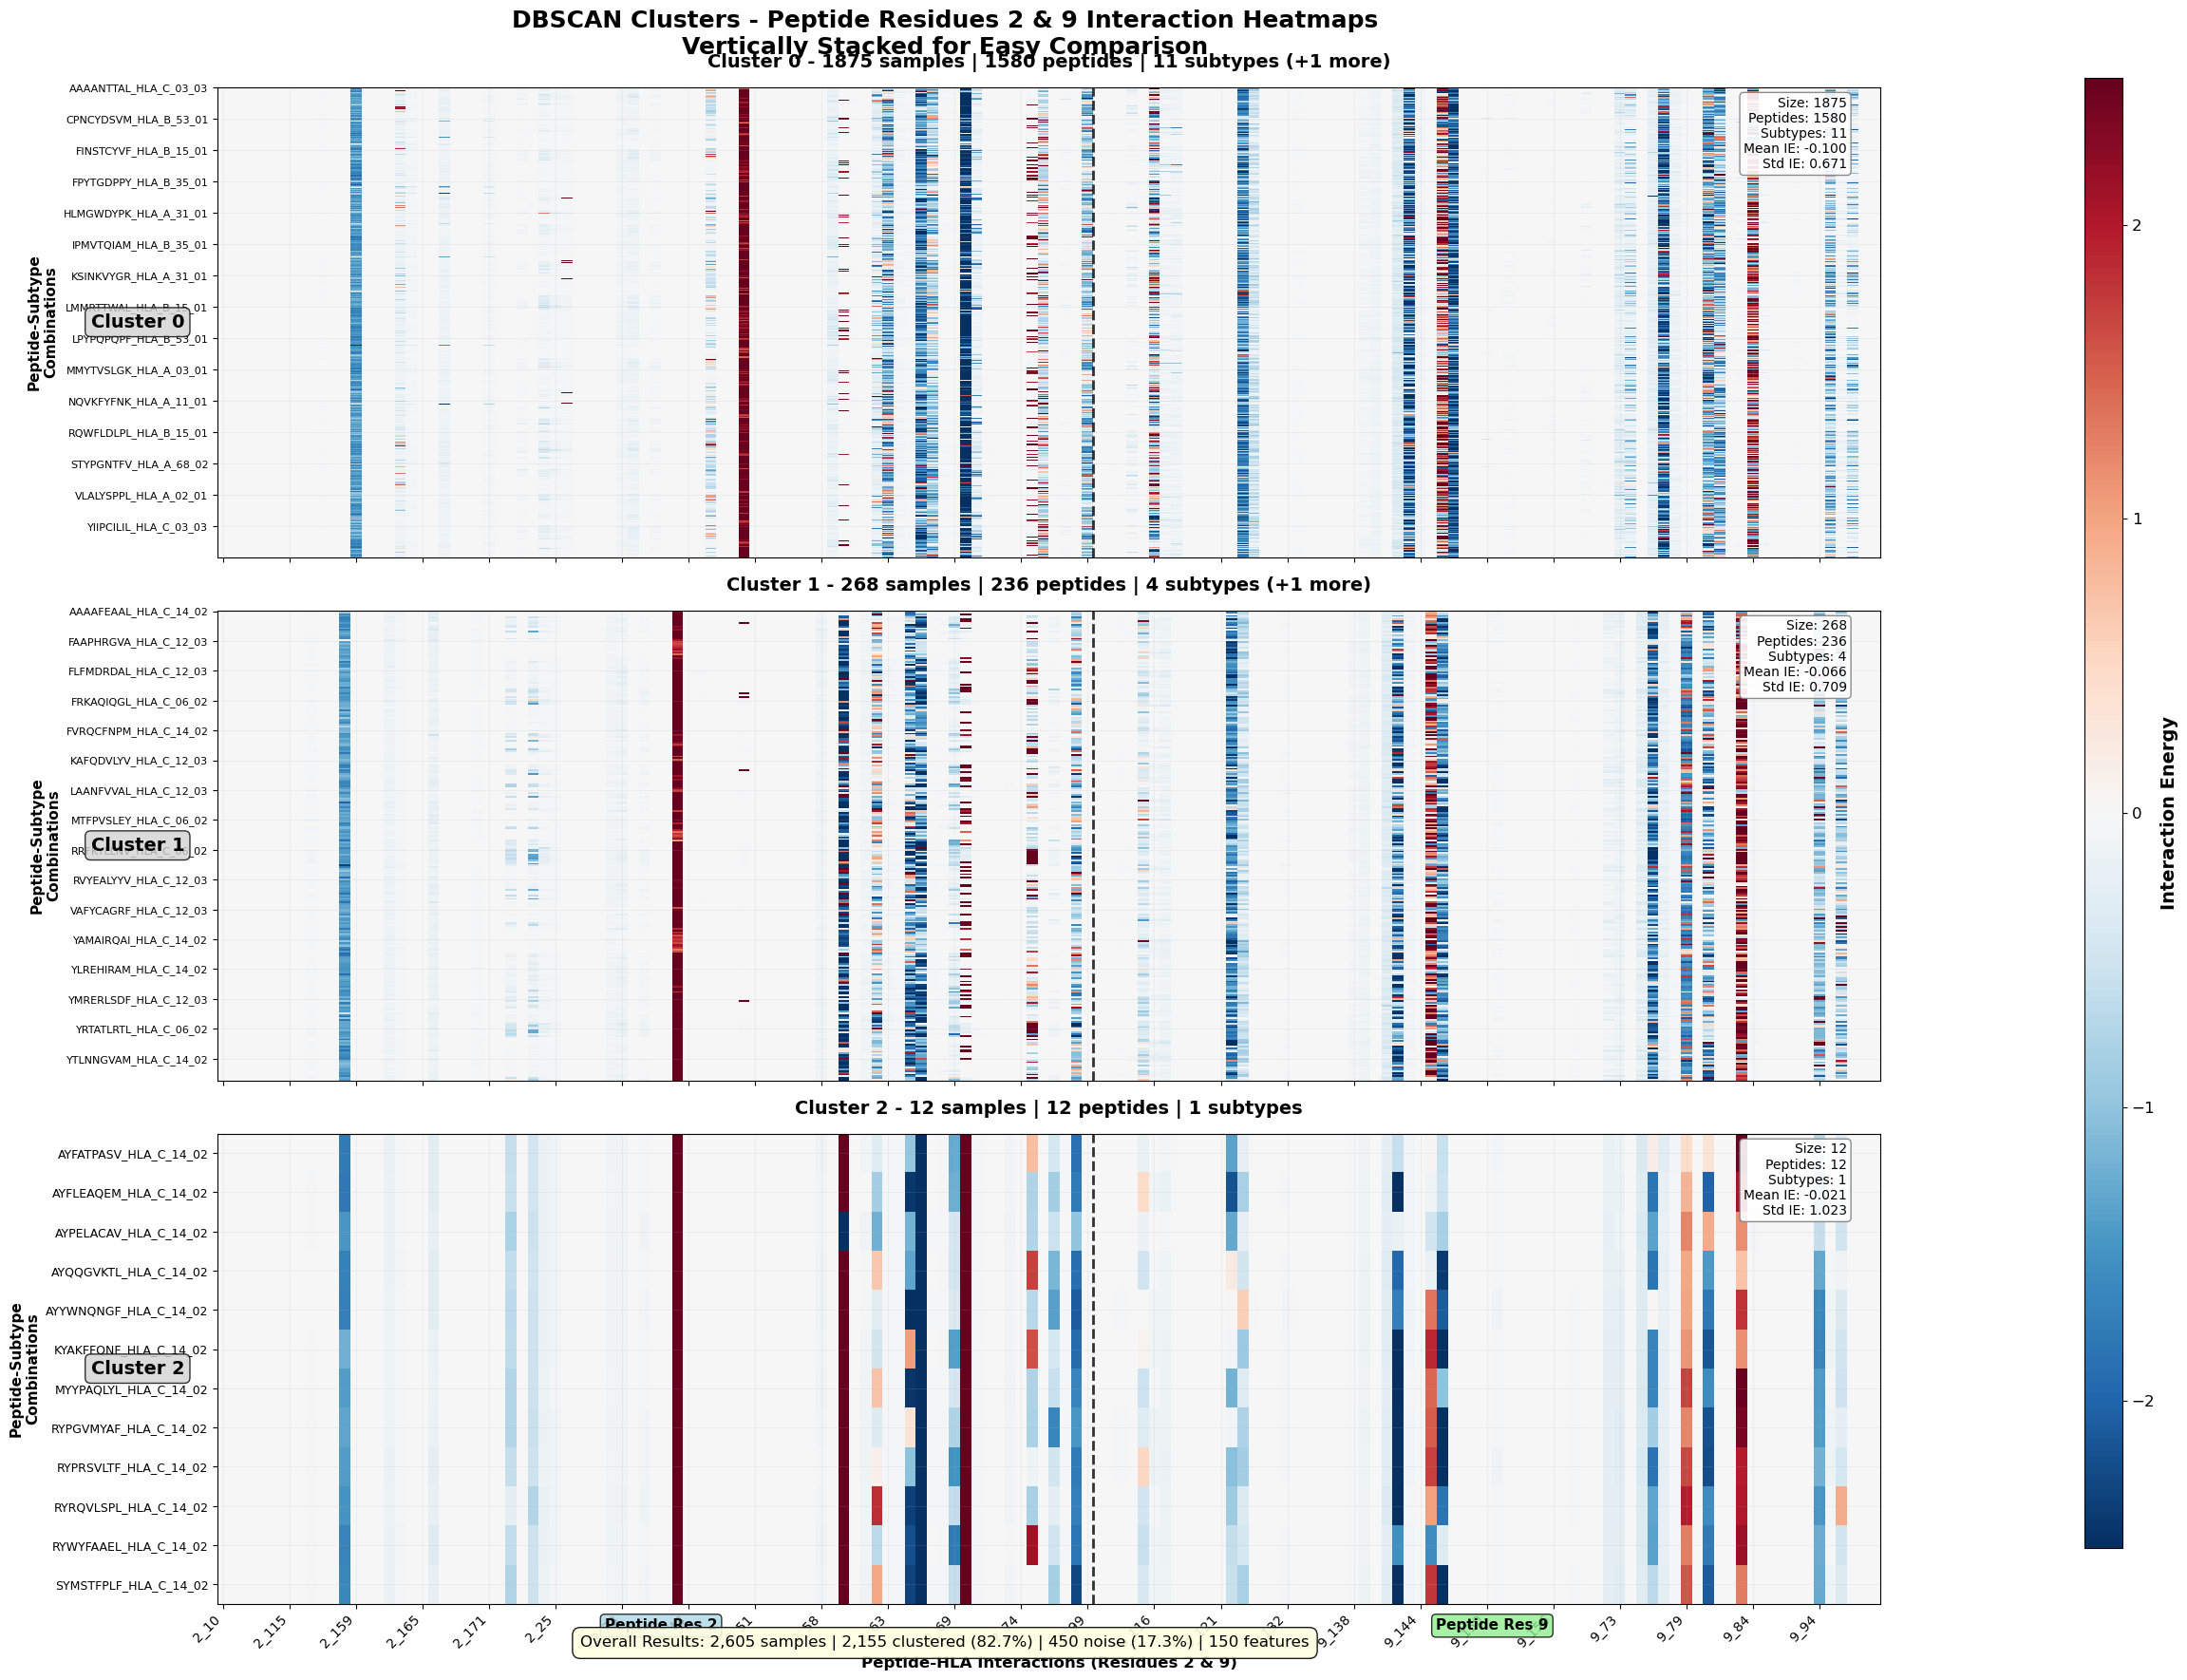


VERTICAL STACK COMPARISON SUMMARY

Cluster comparison (top to bottom):

Cluster 0 (Row 1):
  📊 Size: 1875 samples
  🧬 Diversity: 1580 peptides, 11 subtypes
  ⚡ Energy: mean=-0.100, std=0.671
  🔍 Most distinctive interactions:
      • 2_7 (Pep2-HLA7): -2.534 (diff: 6.275)
      • 2_4 (Pep2-HLA4): 0.000 (diff: 5.275)
      • 2_5 (Pep2-HLA5): 3.534 (diff: 3.506)

Cluster 1 (Row 2):
  📊 Size: 268 samples
  🧬 Diversity: 236 peptides, 4 subtypes
  ⚡ Energy: mean=-0.066, std=0.709
  🔍 Most distinctive interactions:
      • 2_6 (Pep2-HLA6): -1.533 (diff: 3.445)
      • 2_5 (Pep2-HLA5): 0.056 (diff: 1.711)
      • 9_79 (Pep9-HLA79): -0.804 (diff: 1.412)

Cluster 2 (Row 3):
  📊 Size: 12 samples
  🧬 Diversity: 12 peptides, 1 subtypes
  ⚡ Energy: mean=-0.021, std=1.023
  🔍 Most distinctive interactions:
      • 2_7 (Pep2-HLA7): 6.545 (diff: 7.344)
      • 2_4 (Pep2-HLA4): 6.643 (diff: 4.689)
      • 2_6 (Pep2-HLA6): 3.570 (diff: 4.210)

✅ Vertically stacked visualization complete!
✅ All 3 cluster

In [45]:
# VERTICALLY STACKED HEATMAPS - BETTER COMPARISON
print("Creating vertically stacked heatmaps for better comparison...")

# Create figure with vertically stacked subplots (rows, not columns)
n_clusters = len(cluster_info_simple)
fig_height = max(16, 6 * n_clusters)  # Adjust height based on number of clusters
fig, axes = plt.subplots(n_clusters, 1, figsize=(20, fig_height))

# Make sure axes is always a list for consistent indexing
if n_clusters == 1:
    axes = [axes]

fig.suptitle('DBSCAN Clusters - Peptide Residues 2 & 9 Interaction Heatmaps\nVertically Stacked for Easy Comparison', 
             fontsize=18, fontweight='bold', y=0.98)

# Define consistent color scale for all heatmaps
vmin_global = -2.5
vmax_global = 2.5

# Store cluster matrices for comparison
cluster_matrices_stacked = []

for i, (cluster_id, cluster_size) in enumerate(cluster_info_simple):
    print(f"Creating heatmap for Cluster {cluster_id} ({cluster_size} samples)...")
    
    # Get samples in this cluster
    cluster_mask = sample_info_simple['cluster'] == cluster_id
    cluster_data = sample_info_simple[cluster_mask].copy()
    
    # Get interaction matrix for this cluster
    cluster_matrix = X_residues_2_9.loc[cluster_data.index]
    cluster_matrices_stacked.append(cluster_matrix)
    
    # Get cluster information
    unique_peptides = cluster_data['peptide'].nunique()
    unique_subtypes = cluster_data['subtype'].nunique()
    top_subtypes = cluster_data['subtype'].value_counts().head(3)
    
    # Create peptide-subtype labels for y-axis
    peptide_subtype_labels = [f"{row['peptide']}_{row['subtype']}" for _, row in cluster_data.iterrows()]
    
    # Create heatmap in the current subplot
    ax = axes[i]
    im = ax.imshow(cluster_matrix.values, cmap='RdBu_r', aspect='auto', 
                   vmin=vmin_global, vmax=vmax_global, interpolation='nearest')
    
    # Enhanced title with cluster information
    dominant_subtypes = list(top_subtypes.head(2).index)
    title = f'Cluster {cluster_id} - {cluster_size} samples | {unique_peptides} peptides | {unique_subtypes} subtypes'
    if len(top_subtypes) > 2:
        title += f' (+{len(top_subtypes)-2} more)'
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # X-axis: Features (interactions) - only label for bottom plot
    n_features = len(residues_2_9_features)
    
    # Separate residue 2 and 9 features for better labeling
    res2_features = [f for f in residues_2_9_features if f.startswith('2_')]
    res9_features = [f for f in residues_2_9_features if f.startswith('9_')]
    
    # Set x-axis ticks with better spacing
    step_x = max(1, n_features // 25)  # Show more labels since we have more horizontal space
    x_positions = range(0, n_features, step_x)
    x_labels = []
    for pos in x_positions:
        feature = residues_2_9_features[pos]
        pep_res, hla_res = feature.split('_')
        x_labels.append(f'{pep_res}_{hla_res}')
    
    ax.set_xticks(x_positions)
    
    # Only show x-axis labels on the bottom plot
    if i == n_clusters - 1:  # Last (bottom) subplot
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
        ax.set_xlabel('Peptide-HLA Interactions (Residues 2 & 9)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels([])  # Hide x-axis labels for upper plots
    
    # Add vertical line to separate residue 2 and 9 features
    if len(res2_features) > 0 and len(res9_features) > 0:
        separator_pos = len(res2_features) - 0.5
        ax.axvline(x=separator_pos, color='black', linestyle='--', linewidth=2, alpha=0.8)
        
        # Add text labels for residue regions (only on bottom plot to avoid clutter)
        if i == n_clusters - 1:
            ax.text(len(res2_features)/2, cluster_size + cluster_size*0.02, 'Peptide Res 2', 
                    ha='center', va='bottom', fontsize=11, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
            ax.text(len(res2_features) + len(res9_features)/2, cluster_size + cluster_size*0.02, 'Peptide Res 9', 
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))
    
    # Y-axis: Samples
    ax.set_ylabel(f'Peptide-Subtype\nCombinations', fontsize=11, fontweight='bold')
    
    # Adjust y-axis labels based on cluster size
    if cluster_size <= 25:
        # Show all labels for small clusters
        ax.set_yticks(range(cluster_size))
        ax.set_yticklabels([label[:30] + '...' if len(label) > 30 else label 
                           for label in peptide_subtype_labels], fontsize=9)
    elif cluster_size <= 100:
        # Show sample of labels for medium clusters
        step_y = max(1, cluster_size // 20)
        y_positions = range(0, cluster_size, step_y)
        y_labels = [peptide_subtype_labels[j][:30] + '...' if len(peptide_subtype_labels[j]) > 30 
                   else peptide_subtype_labels[j] for j in y_positions]
        ax.set_yticks(y_positions)
        ax.set_yticklabels(y_labels, fontsize=9)
    else:
        # Show fewer labels for large clusters
        step_y = max(1, cluster_size // 15)
        y_positions = range(0, cluster_size, step_y)
        y_labels = [peptide_subtype_labels[j][:25] + '...' if len(peptide_subtype_labels[j]) > 25 
                   else peptide_subtype_labels[j] for j in y_positions]
        ax.set_yticks(y_positions)
        ax.set_yticklabels(y_labels, fontsize=8)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.2, linewidth=0.5)
    
    # Add statistics text box in upper right
    mean_energy = cluster_matrix.values.mean()
    std_energy = cluster_matrix.values.std()
    stats_text = f'Size: {cluster_size}\nPeptides: {unique_peptides}\nSubtypes: {unique_subtypes}\nMean IE: {mean_energy:.3f}\nStd IE: {std_energy:.3f}'
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Add cluster identifier on the left
    ax.text(-0.02, 0.5, f'Cluster {cluster_id}', transform=ax.transAxes, fontsize=14,
            verticalalignment='center', horizontalalignment='right', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# Add shared colorbar on the right
plt.subplots_adjust(right=0.88, top=0.94, bottom=0.08, hspace=0.3)
cbar_ax = fig.add_axes([1.1, 0.08, 0.02, 0.86])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Interaction Energy', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Add overall statistics at the bottom
stats_text = f"""Overall Results: {len(final_labels_simple):,} samples | {n_clustered_final_simple:,} clustered ({100*n_clustered_final_simple/len(final_labels_simple):.1f}%) | {n_noise_final_simple:,} noise ({100*n_noise_final_simple/len(final_labels_simple):.1f}%) | {len(residues_2_9_features)} features"""

fig.text(0.5, 0.02, stats_text, ha='center', va='bottom', fontsize=12, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

# Summary comparison between clusters
print("\n" + "="*80)
print("VERTICAL STACK COMPARISON SUMMARY")
print("="*80)

print(f"\nCluster comparison (top to bottom):")
for i, (cluster_id, cluster_size) in enumerate(cluster_info_simple):
    cluster_matrix = cluster_matrices_stacked[i]
    cluster_data = sample_info_simple[sample_info_simple['cluster'] == cluster_id]
    
    mean_energy = cluster_matrix.values.mean()
    std_energy = cluster_matrix.values.std()
    dominant_hla = cluster_data['subtype'].value_counts().index[0]
    
    print(f"\nCluster {cluster_id} (Row {i+1}):")
    print(f"  📊 Size: {cluster_size} samples")
    print(f"  🧬 Diversity: {cluster_data['peptide'].nunique()} peptides, {cluster_data['subtype'].nunique()} subtypes")
    print(f"  ⚡ Energy: mean={mean_energy:.3f}, std={std_energy:.3f}")
    
    # Find most distinctive interactions for this cluster
    if len(cluster_matrices_stacked) > 1:
        # Compare with other clusters
        other_matrices = [cluster_matrices_stacked[j] for j in range(len(cluster_matrices_stacked)) if j != i]
        current_means = cluster_matrix.mean()
        other_means = pd.concat([m.mean() for m in other_matrices], axis=1).mean(axis=1)
        
        # Find features with largest difference
        differences = (current_means - other_means).abs().sort_values(ascending=False)
        top_distinctive = differences.head(3)
        
        print(f"  🔍 Most distinctive interactions:")
        for feature, diff in top_distinctive.items():
            pep_res, hla_res = feature.split('_')
            current_val = current_means[feature]
            print(f"      • {feature} (Pep{pep_res}-HLA{hla_res}): {current_val:.3f} (diff: {diff:.3f})")

print(f"\n✅ Vertically stacked visualization complete!")
print(f"✅ All {n_clusters} clusters shown in rows for easy comparison")
print(f"✅ Consistent scale and layout across all heatmaps")
print(f"✅ Clear separation between peptide residues 2 & 9 regions")

Standardizing A/B interactions: 100%|██████████| 483464/483464 [00:14<00:00, 32755.80it/s]
/tmp/ipykernel_2223939/2115899298.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_vectors = df_std.groupby(['peptide', 'subtype']).apply(create_feature_vector)



Searching for multi-cluster solutions (DBSCAN + KMeans + Agglomerative + GMM)

Top clustering candidates (sorted by silhouette):
                  method  k  silhouette  min_size  noise_pct
DBSCAN(eps=11.741,ms=15)  2       0.662        15      7.057
 DBSCAN(eps=10.764,ms=8)  2       0.651        21      7.407
DBSCAN(eps=11.090,ms=10)  2       0.645        22      7.057
 DBSCAN(eps=11.090,ms=8)  2       0.643        25      6.607
DBSCAN(eps=11.416,ms=10)  2       0.643        23      6.757
                  KMeans  2       0.641       113      0.000
                     GMM  2       0.641       113      0.000
     Agglomerative(Ward)  2       0.641       113      0.000
DBSCAN(eps=11.416,ms=12)  2       0.641        20      6.957
DBSCAN(eps=11.741,ms=12)  2       0.640        22      6.657

Selected partition → DBSCAN(eps=11.741,ms=15) | k=2 | silhouette=0.662


/tmp/ipykernel_2223939/2115899298.py:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


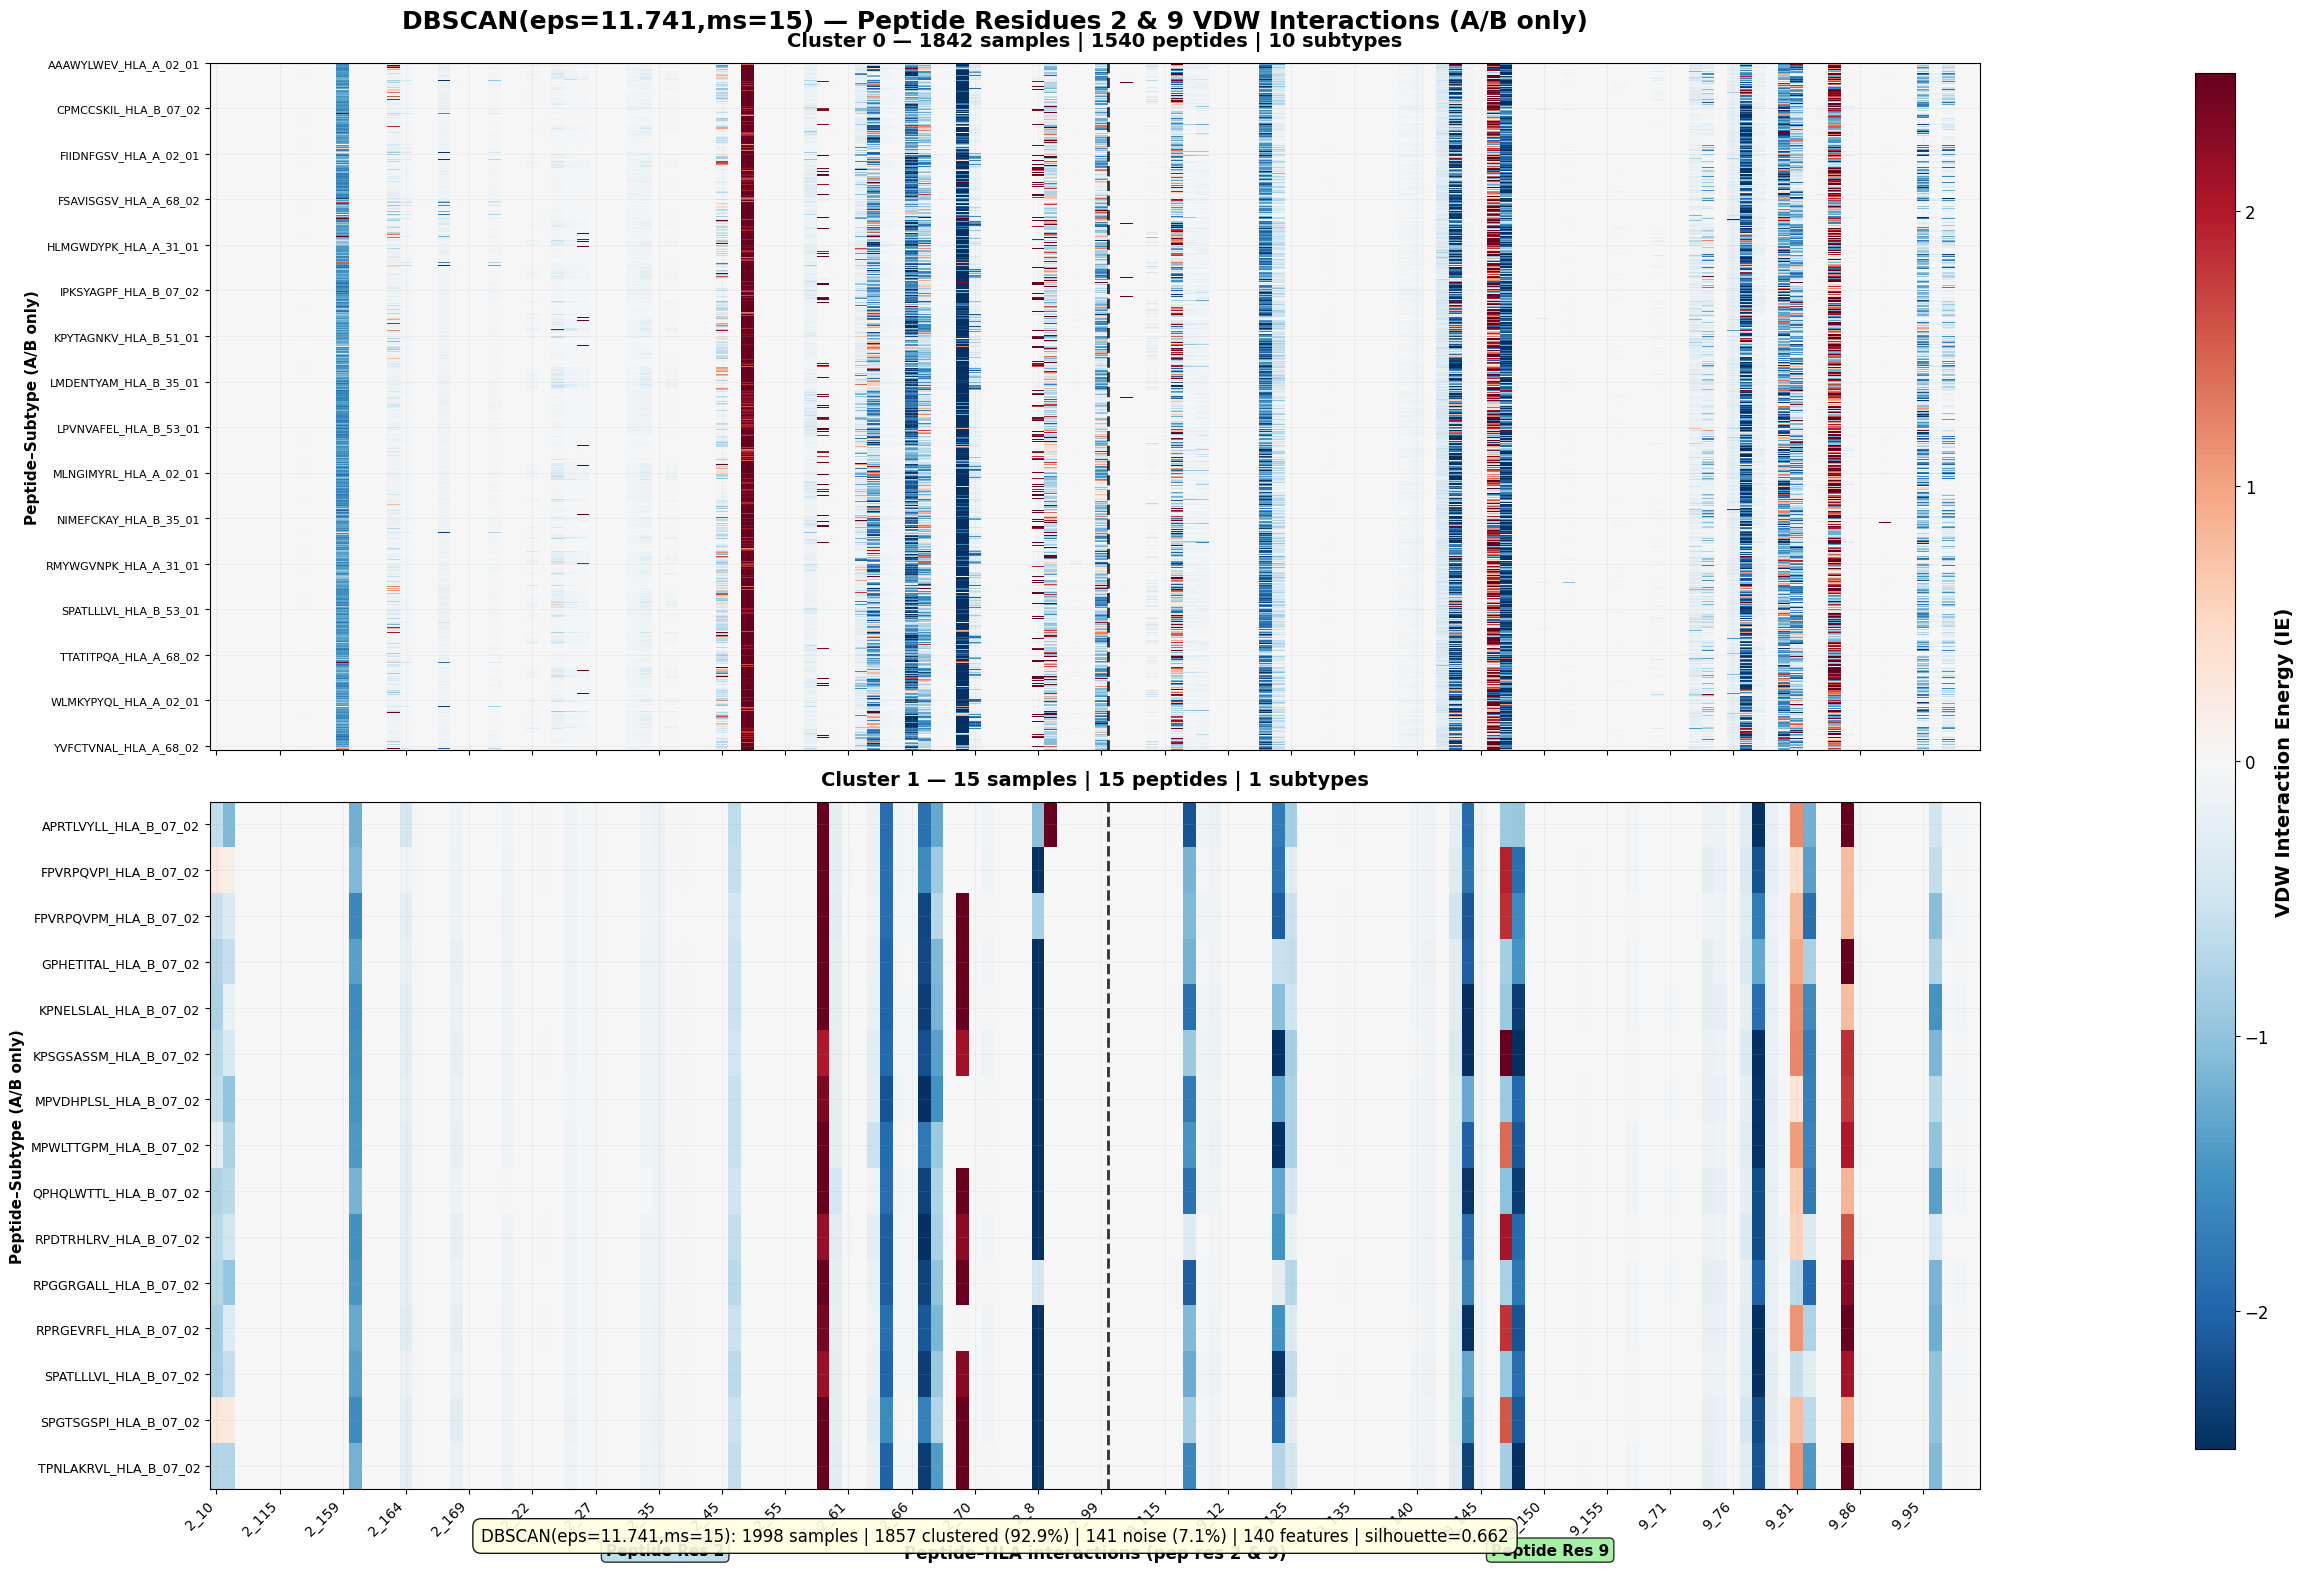


Selecting 5 candidates per cluster

=== Selected 5 per cluster → total 10 candidates ===
            tag  cluster   peptide     subtype  mean_vdw  DOPE  silhouette  dist_to_centroid  distinct_score
    best_energy        0 MMLVPLITV HLA_A_02_01   -0.2123   NaN      0.6399            8.0129          1.1016
       boundary        0 MLYDRINLR HLA_A_31_01   -0.0832   NaN      0.3155           22.6329         -1.0939
 cluster_medoid        0 FTNPLFYHK HLA_A_31_01   -0.1059   NaN      0.7328            3.3079          1.1527
    distinctive        0 LMDENTYAM HLA_B_35_01   -0.0223   NaN      0.6434            8.2730          2.1684
high_silhouette        0 EPLAVIASL HLA_B_35_01   -0.1365   NaN      0.7336            3.4073          1.2325
    best_energy        1 MPVDHPLSL HLA_B_07_02   -0.1785   NaN      0.6180            7.4105         27.2060
       boundary        1 RPDTRHLRV HLA_B_07_02   -0.1131   NaN      0.4963            9.7118         22.1912
 cluster_medoid        1 TPNLAKRVL HLA

In [7]:
# --- 0) Setup & data ----------------------------------------------------------
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples
import tqdm
from collections import Counter
import re

plt.style.use('default')
sns.set_palette("husl")

# --- Configs (optional) -------------------------------------------------------
DOPE_CSV_PATH = None         # e.g. "/path/dope.csv" with columns [peptide, subtype, DOPE]
N_PER_CLUSTER = 5            # pick this many per cluster

# --- Load VDW-only table (IE column holds VDW energy) -------------------------
df_ie_master = pd.read_excel('/opt/experiments/pep_hla_dynamics/data_compiled/df_ie_master_vdw.xlsx')

# --- 1) Keep only HLA-A and HLA-B subtypes -----------------------------------
df_ie_master = df_ie_master[df_ie_master['subtype'].str.startswith(('HLA_A', 'HLA_B'))].copy()

# --- 2) Keep peptide–HLA (C–A or A–C) interactions only ----------------------
peptide_hla = df_ie_master[
    ((df_ie_master['res1_chid'] == 'C') & (df_ie_master['res2_chid'] == 'A')) |
    ((df_ie_master['res1_chid'] == 'A') & (df_ie_master['res2_chid'] == 'C'))
].copy()

# --- 3) Standardize rows so that peptide residue is always first --------------
def standardize_interaction(row):
    """Ensure peptide residue info comes first and HLA residue info second."""
    if row['res1_chid'] == 'C':
        return {
            'peptide_resnum': row['res1_resnum'],
            'hla_resnum': row['res2_resnum'],
            'peptide_index': row['res1_index'],
            'hla_index': row['res2_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }
    else:
        return {
            'peptide_resnum': row['res2_resnum'],
            'hla_resnum': row['res1_resnum'],
            'peptide_index': row['res2_index'],
            'hla_index': row['res1_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }

std_rows = [standardize_interaction(r) for _, r in tqdm.tqdm(peptide_hla.iterrows(),
                                                             total=len(peptide_hla),
                                                             desc="Standardizing A/B interactions")]
df_std = pd.DataFrame(std_rows)

# --- 4) Build feature vectors: (peptide, subtype) → IE vector -----------------
def create_feature_vector(group):
    """Return a 1D Series of IE values indexed by 'pepRes_hlaRes', sorted for consistency."""
    g = group.sort_values(['peptide_resnum', 'hla_resnum']).copy()
    g['interaction_id'] = g['peptide_resnum'].astype(str) + '_' + g['hla_resnum'].astype(str)
    return pd.Series(g['IE'].values, index=g['interaction_id'])

feature_vectors = df_std.groupby(['peptide', 'subtype']).apply(create_feature_vector)
clustering_matrix = feature_vectors.unstack(level=-1).fillna(0)

# Sample meta (row index is MultiIndex (peptide, subtype))
sample_info = pd.DataFrame(clustering_matrix.index.tolist(), columns=['peptide', 'subtype'])
sample_info.index = clustering_matrix.index

# --- 5) Keep only features for peptide residues 2 & 9 -------------------------
residues_2_9_cols = [c for c in clustering_matrix.columns if c.split('_')[0] in ('2','9')]
X_29 = clustering_matrix[residues_2_9_cols].copy()

# Scale features for distance-based algorithms
scaler = StandardScaler()
X_29_scaled = scaler.fit_transform(X_29)

# -------------------------- Helper functions ----------------------------------
def eval_partition(labels: np.ndarray):
    """Compute basic stats for a label vector where noise is -1 (DBSCAN-style)."""
    n = len(labels)
    n_noise = int((labels == -1).sum()) if isinstance(labels, np.ndarray) else 0
    labs = [l for l in set(labels) if l != -1]
    n_clusters = len(labs)
    sizes = [int((labels == lab).sum()) for lab in labs]
    min_size = min(sizes) if sizes else 0
    clustered = n - n_noise
    noise_pct = 100.0 * n_noise / n
    return dict(n_clusters=n_clusters, sizes=sizes, min_size=min_size,
                n_noise=n_noise, noise_pct=noise_pct, clustered=clustered)

def try_agglomerative(X, k, linkage='ward', metric='euclidean'):
    """AgglomerativeClustering with version-compatible args."""
    try:
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=metric)
    except TypeError:
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage, affinity=metric)
    return model.fit_predict(X)

def try_kmeans(X, k, random_state=0):
    return KMeans(n_clusters=k, n_init=20, random_state=random_state).fit_predict(X)

def try_gmm(X, k, random_state=0):
    return GaussianMixture(n_components=k, covariance_type='full', n_init=5, random_state=random_state).fit_predict(X)

# --- 6) Multi-method search (DBSCAN + KMeans + Agglomerative + GMM) -----------
print("\n" + "="*80)
print("Searching for multi-cluster solutions (DBSCAN + KMeans + Agglomerative + GMM)")

min_cluster_size_req = 10
noise_max_pct = 40.0
K_range = range(2, 9)
candidates = []

# 6A) DBSCAN grid, seeded by k-distance elbow
k_nn = max(5, min_cluster_size_req)
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X_29_scaled)
dists, _ = nbrs.kneighbors(X_29_scaled)
d_sorted = np.sort(dists[:, k_nn-1])[::-1]
grad = np.gradient(d_sorted)
offset = min(50, max(0, len(grad)//10))
elbow_idx = np.argmax(grad[offset:]) + offset if len(grad) > 0 else 0
eps0 = float(d_sorted[elbow_idx]) if len(d_sorted) > 0 else 0.5

eps_grid = np.linspace(eps0*0.2, eps0*2.5, 36)
min_samples_grid = [6, 8, 10, 12, 15, 20]

for eps in eps_grid:
    for ms in min_samples_grid:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_29_scaled)
        stats = eval_partition(labels)
        if stats['n_clusters'] >= 2 and stats['min_size'] >= min_cluster_size_req and stats['noise_pct'] <= noise_max_pct:
            mask = (labels != -1)
            if mask.sum() > 1 and len(set(labels[mask])) >= 2:
                sil = silhouette_score(X_29_scaled[mask], labels[mask], metric='euclidean')
                candidates.append({'method': f"DBSCAN(eps={eps:.3f},ms={ms})",
                                   'k': stats['n_clusters'], 'silhouette': sil,
                                   **stats, 'labels': labels})

# 6B) KMeans / Agglomerative / GMM for K=2..8
for k in K_range:
    lbl = try_agglomerative(X_29_scaled, k, linkage='ward', metric='euclidean')
    s = eval_partition(lbl)
    if s['min_size'] >= min_cluster_size_req:
        sil = silhouette_score(X_29_scaled, lbl, metric='euclidean')
        candidates.append({'method':'Agglomerative(Ward)', 'k':k, 'silhouette':sil, **s, 'labels':lbl})

    lbl = try_agglomerative(X_29_scaled, k, linkage='average', metric='cosine')
    s = eval_partition(lbl)
    if s['min_size'] >= min_cluster_size_req:
        sil = silhouette_score(X_29_scaled, lbl, metric='cosine')
        candidates.append({'method':'Agglomerative(Average+Cosine)', 'k':k, 'silhouette':sil, **s, 'labels':lbl})

    lbl = try_kmeans(X_29_scaled, k)
    s = eval_partition(lbl)
    if s['min_size'] >= min_cluster_size_req:
        sil = silhouette_score(X_29_scaled, lbl, metric='euclidean')
        candidates.append({'method':'KMeans', 'k':k, 'silhouette':sil, **s, 'labels':lbl})

    lbl = try_gmm(X_29_scaled, k)
    s = eval_partition(lbl)
    if s['min_size'] >= min_cluster_size_req:
        sil = silhouette_score(X_29_scaled, lbl, metric='euclidean')
        candidates.append({'method':'GMM', 'k':k, 'silhouette':sil, **s, 'labels':lbl})

if len(candidates) == 0:
    print("No candidate satisfied constraints. Falling back to Agglomerative(Ward, k=2).")
    lbl = try_agglomerative(X_29_scaled, 2, linkage='ward', metric='euclidean')
    s = eval_partition(lbl)
    sil = silhouette_score(X_29_scaled, lbl, metric='euclidean')
    candidates.append({'method':'Agglomerative(Ward)', 'k':2, 'silhouette':sil, **s, 'labels':lbl})

cand_df = pd.DataFrame([{
    'method': c['method'], 'k': c['k'], 'silhouette': c['silhouette'],
    'min_size': c['min_size'], 'noise_pct': c.get('noise_pct', 0.0)
} for c in candidates]).sort_values('silhouette', ascending=False)

print("\nTop clustering candidates (sorted by silhouette):")
print(cand_df.head(10).to_string(index=False, float_format=lambda x: f"{x:.3f}"))

best = max(candidates, key=lambda c: c['silhouette'])
labels = best['labels']
final_method, final_k = best['method'], best['k']
print(f"\nSelected partition → {final_method} | k={final_k} | silhouette={best['silhouette']:.3f}")

# --- 7) Plot vertically-stacked heatmaps for the selected partition -----------
sample_info_ab = sample_info.copy()
sample_info_ab['cluster'] = labels

valid_mask = sample_info_ab['cluster'] != -1 if -1 in sample_info_ab['cluster'].values else np.ones(len(sample_info_ab), dtype=bool)
sample_info_valid = sample_info_ab[valid_mask]
labels_valid = sample_info_valid['cluster'].values

unique = sorted([lab for lab in set(labels_valid)])
cluster_info = [(cid, int((labels_valid == cid).sum())) for cid in unique]

n_clusters = len(cluster_info)
fig_h = max(16, 6*n_clusters)
fig, axes = plt.subplots(n_clusters, 1, figsize=(20, fig_h))
if n_clusters == 1: axes = [axes]
fig.suptitle(f'{final_method} — Peptide Residues 2 & 9 VDW Interactions (A/B only)',
             fontsize=18, fontweight='bold', y=0.98)

vmin_global, vmax_global = -2.5, 2.5
cluster_mats = []

res2 = [c for c in residues_2_9_cols if c.startswith('2_')]
res9 = [c for c in residues_2_9_cols if c.startswith('9_')]

for i, (cid, csize) in enumerate(cluster_info):
    mask = (sample_info_valid['cluster'] == cid)
    cmeta = sample_info_valid[mask]
    cmatrix = X_29.loc[cmeta.index]
    cluster_mats.append(cmatrix)

    ax = axes[i]
    im = ax.imshow(cmatrix.values, cmap='RdBu_r', aspect='auto',
                   vmin=vmin_global, vmax=vmax_global, interpolation='nearest')

    ax.set_title(f'Cluster {cid} — {csize} samples | {cmeta.peptide.nunique()} peptides | {cmeta.subtype.nunique()} subtypes',
                 fontsize=14, fontweight='bold', pad=12)

    nfeat = len(residues_2_9_cols)
    step_x = max(1, nfeat//25)
    x_pos = range(0, nfeat, step_x)
    x_labs = [residues_2_9_cols[p] for p in x_pos]
    ax.set_xticks(x_pos)
    if i == n_clusters - 1:
        ax.set_xticklabels(x_labs, rotation=45, ha='right', fontsize=10)
        ax.set_xlabel('Peptide–HLA interactions (pep res 2 & 9)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels([])

    if len(res2) > 0 and len(res9) > 0:
        ax.axvline(x=len(res2) - 0.5, color='black', linestyle='--', linewidth=2, alpha=0.8)
        if i == n_clusters - 1:
            ax.text(len(res2)/2, csize + max(1,int(csize*0.02)), 'Peptide Res 2',
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
            ax.text(len(res2)+len(res9)/2, csize + max(1,int(csize*0.02)), 'Peptide Res 9',
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

    ylabels = [f"{r.peptide}_{r.subtype}" for _, r in cmeta.iterrows()]
    if csize <= 25:
        ax.set_yticks(range(csize))
        ax.set_yticklabels([s if len(s)<=30 else s[:30]+'…' for s in ylabels], fontsize=9)
    elif csize <= 100:
        step_y = max(1, csize//20)
        pos = range(0, csize, step_y)
        ax.set_yticks(pos)
        ax.set_yticklabels([ylabels[j] if len(ylabels[j])<=30 else ylabels[j][:30]+'…' for j in pos], fontsize=9)
    else:
        step_y = max(1, csize//15)
        pos = range(0, csize, step_y)
        ax.set_yticks(pos)
        ax.set_yticklabels([ylabels[j] if len(ylabels[j])<=25 else ylabels[j][:25]+'…' for j in pos], fontsize=8)

    ax.set_ylabel('Peptide–Subtype (A/B only)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2, linewidth=0.5)

plt.subplots_adjust(right=0.88, top=0.94, bottom=0.08, hspace=0.3)
cax = fig.add_axes([1.1, 0.08, 0.02, 0.86])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('VDW Interaction Energy (IE)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

n_total = len(sample_info_ab)
n_noise = int((sample_info_ab['cluster'] == -1).sum()) if -1 in sample_info_ab['cluster'].values else 0
n_clustered = n_total - n_noise
stats = (f"{final_method}: {n_total} samples | {n_clustered} clustered "
         f"({100*n_clustered/n_total:.1f}%) | {n_noise} noise ({100*n_noise/n_total:.1f}%) | "
         f"{len(residues_2_9_cols)} features | silhouette={best['silhouette']:.3f}")
fig.text(0.5, 0.02, stats, ha='center', va='bottom', fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

# --- 8) Per-cluster selection: exactly N_PER_CLUSTER from EACH cluster --------
print("\n" + "="*80)
print(f"Selecting {N_PER_CLUSTER} candidates per cluster")

# Build aligned matrices for valid subset
X_scaled_df = pd.DataFrame(X_29_scaled, index=X_29.index)
X_unscaled_v = X_29.loc[sample_info_valid.index]
X_scaled_v   = X_scaled_df.loc[sample_info_valid.index].values
clusters_v   = labels_valid

# Per-sample metrics
mean_vdw = X_unscaled_v.mean(axis=1)

try:
    sil_samples = silhouette_samples(X_scaled_v, clusters_v, metric='euclidean')
except Exception:
    sil_samples = np.full(len(clusters_v), np.nan)

# Distances to centroids and “distinctiveness” per cluster
dist_to_centroid = np.zeros(len(clusters_v), dtype=float)
distinct_scores  = np.zeros(len(clusters_v), dtype=float)
X_scaled_v_df    = pd.DataFrame(X_scaled_v, index=X_unscaled_v.index)

for cid in np.unique(clusters_v):
    mask_in  = (clusters_v == cid)
    C = X_scaled_v_df[mask_in].mean(axis=0).values
    dist_to_centroid[mask_in] = np.linalg.norm(X_scaled_v[mask_in] - C, axis=1)
    mask_out = ~mask_in
    if mask_out.sum() > 0:
        v = C - X_scaled_v_df[mask_out].mean(axis=0).values
        vn = np.linalg.norm(v)
        if vn > 0:
            v = v / vn
            distinct_scores[mask_in] = (X_scaled_v[mask_in] @ v)

# Optional DOPE merge
dope = pd.Series(np.nan, index=X_unscaled_v.index)
if DOPE_CSV_PATH:
    try:
        df_dope = pd.read_csv(DOPE_CSV_PATH)
        pep_col = next((c for c in df_dope.columns if c.lower()=='peptide'), None)
        sub_col = next((c for c in df_dope.columns if c.lower()=='subtype'), None)
        d_col   = next((c for c in df_dope.columns if c.lower()=='dope'), None)
        if pep_col and sub_col and d_col:
            tmp = df_dope[[pep_col, sub_col, d_col]].copy()
            tmp.columns = ['peptide','subtype','DOPE']
            dope = X_unscaled_v.index.to_series().map(tmp.set_index(['peptide','subtype'])['DOPE'])
        else:
            print("[WARN] DOPE columns not found; skipping DOPE merge.")
    except Exception as e:
        print(f"[WARN] Could not read DOPE file: {e}")

# Meta table for selection (index = (peptide, subtype))
meta = sample_info_valid.copy()
meta['mean_vdw']         = mean_vdw.values
meta['silhouette']       = sil_samples
meta['dist_to_centroid'] = dist_to_centroid
meta['distinct_score']   = distinct_scores
meta['DOPE']             = dope.values

def _take_next(g, col, ascending=True, used=None):
    """Pick first index from g sorted by column (ignores NaNs), not in used."""
    used = used or set()
    s = g[col].copy()
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        return None
    order = s.sort_values(ascending=ascending).index
    for idx in order:
        if idx not in used:
            return idx
    return None

all_records = []

for cid, g in meta.groupby('cluster', sort=True):
    used = set()
    picks = []

    # 1) Cluster medoid
    idx = _take_next(g, 'dist_to_centroid', ascending=True, used=used)
    if idx is not None:
        used.add(idx); picks.append(('cluster_medoid', idx))

    # 2) Best energy (lowest mean VDW)
    idx = _take_next(g, 'mean_vdw', ascending=True, used=used)
    if idx is not None:
        used.add(idx); picks.append(('best_energy', idx))

    # 3) Boundary (lowest silhouette) fallback → farthest from centroid
    idx = _take_next(g, 'silhouette', ascending=True, used=used)
    if idx is None:
        idx = _take_next(g, 'dist_to_centroid', ascending=False, used=used)
    if idx is not None:
        used.add(idx); picks.append(('boundary', idx))

    # 4) Most distinctive (largest projection)
    idx = _take_next(g, 'distinct_score', ascending=False, used=used)
    if idx is not None:
        used.add(idx); picks.append(('distinctive', idx))

    # 5) High-silhouette (well-embedded) OR lowest DOPE if available
    if meta['DOPE'].notna().any():
        idx = _take_next(g, 'DOPE', ascending=True, used=used)
        tag5 = 'lowest_dope'
        if idx is None:  # fall back to high silhouette
            idx = _take_next(g, 'silhouette', ascending=False, used=used)
            tag5 = 'high_silhouette'
    else:
        idx = _take_next(g, 'silhouette', ascending=False, used=used)
        tag5 = 'high_silhouette'
    if idx is None:  # final fallback → nearest center second
        idx = _take_next(g, 'dist_to_centroid', ascending=True, used=used)
        tag5 = 'central_next'
    if idx is not None:
        used.add(idx); picks.append((tag5, idx))

    # Backfill to exactly N_PER_CLUSTER if needed (use distinctiveness then silhouette)
    if len(picks) < N_PER_CLUSTER:
        rest = g.drop(index=list(used)).sort_values(['distinct_score','silhouette'], ascending=[False, False])
        for idx in rest.index[:(N_PER_CLUSTER - len(picks))]:
            used.add(idx); picks.append(('distinctive_next', idx))

    # Materialize rows
    for tag, idx in picks[:N_PER_CLUSTER]:
        row = meta.loc[idx]; pep, sub = idx
        all_records.append({
            'tag': tag,
            'cluster': int(cid),
            'peptide': pep,
            'subtype': sub,
            'mean_vdw': float(row['mean_vdw']),
            'DOPE': (np.nan if pd.isna(row['DOPE']) else float(row['DOPE'])),
            'silhouette': (np.nan if not np.isfinite(row['silhouette']) else float(row['silhouette'])),
            'dist_to_centroid': float(row['dist_to_centroid']),
            'distinct_score': float(row['distinct_score']),
        })

picked_df = pd.DataFrame(all_records, columns=[
    'tag','cluster','peptide','subtype','mean_vdw','DOPE','silhouette','dist_to_centroid','distinct_score'
]).sort_values(['cluster','tag']).reset_index(drop=True)

print(f"\n=== Selected {N_PER_CLUSTER} per cluster → total {len(picked_df)} candidates ===")
print(picked_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x,float) else str(x)))

# Save for traceability
method_clean = re.sub(r'[^A-Za-z0-9_()+-]+', '_', final_method)
out_csv = f"simulation_candidates_perCluster{N_PER_CLUSTER}_{method_clean}_k{n_clusters}.csv"
picked_df.to_csv(out_csv, index=False)
print(f"[OK] Saved -> {out_csv}")


Standardizing A/B interactions: 100%|██████████| 483464/483464 [00:14<00:00, 32855.72it/s]
/tmp/ipykernel_2223939/420220653.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_vectors = df_std.groupby(['peptide', 'subtype']).apply(create_feature_vector)



DBSCAN grid search targeting exactly 3 clusters

Top exact-3 DBSCAN candidates (by silhouette):
   eps  min_samples  silhouette  min_size  noise_pct  noise_limit
11.700            8       0.620        11      5.205       30.000
11.988            8       0.615        12      5.005       30.000
12.565           10       0.614        11      4.955       30.000
12.276            8       0.614        12      4.855       30.000
12.276           10       0.614        10      5.405       30.000
12.853           10       0.613        11      4.805       30.000
12.853            6       0.613        23      4.004       30.000
12.565            8       0.613        12      4.655       30.000
12.853            8       0.612        16      4.404       30.000
13.141            6       0.612        23      3.904       30.000

=== DBSCAN selection ===
Mode: exact-3
eps=11.6998 | min_samples=8 | clusters=3 | min_size=11 | noise=5.2% | silhouette=0.620


/tmp/ipykernel_2223939/420220653.py:296: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


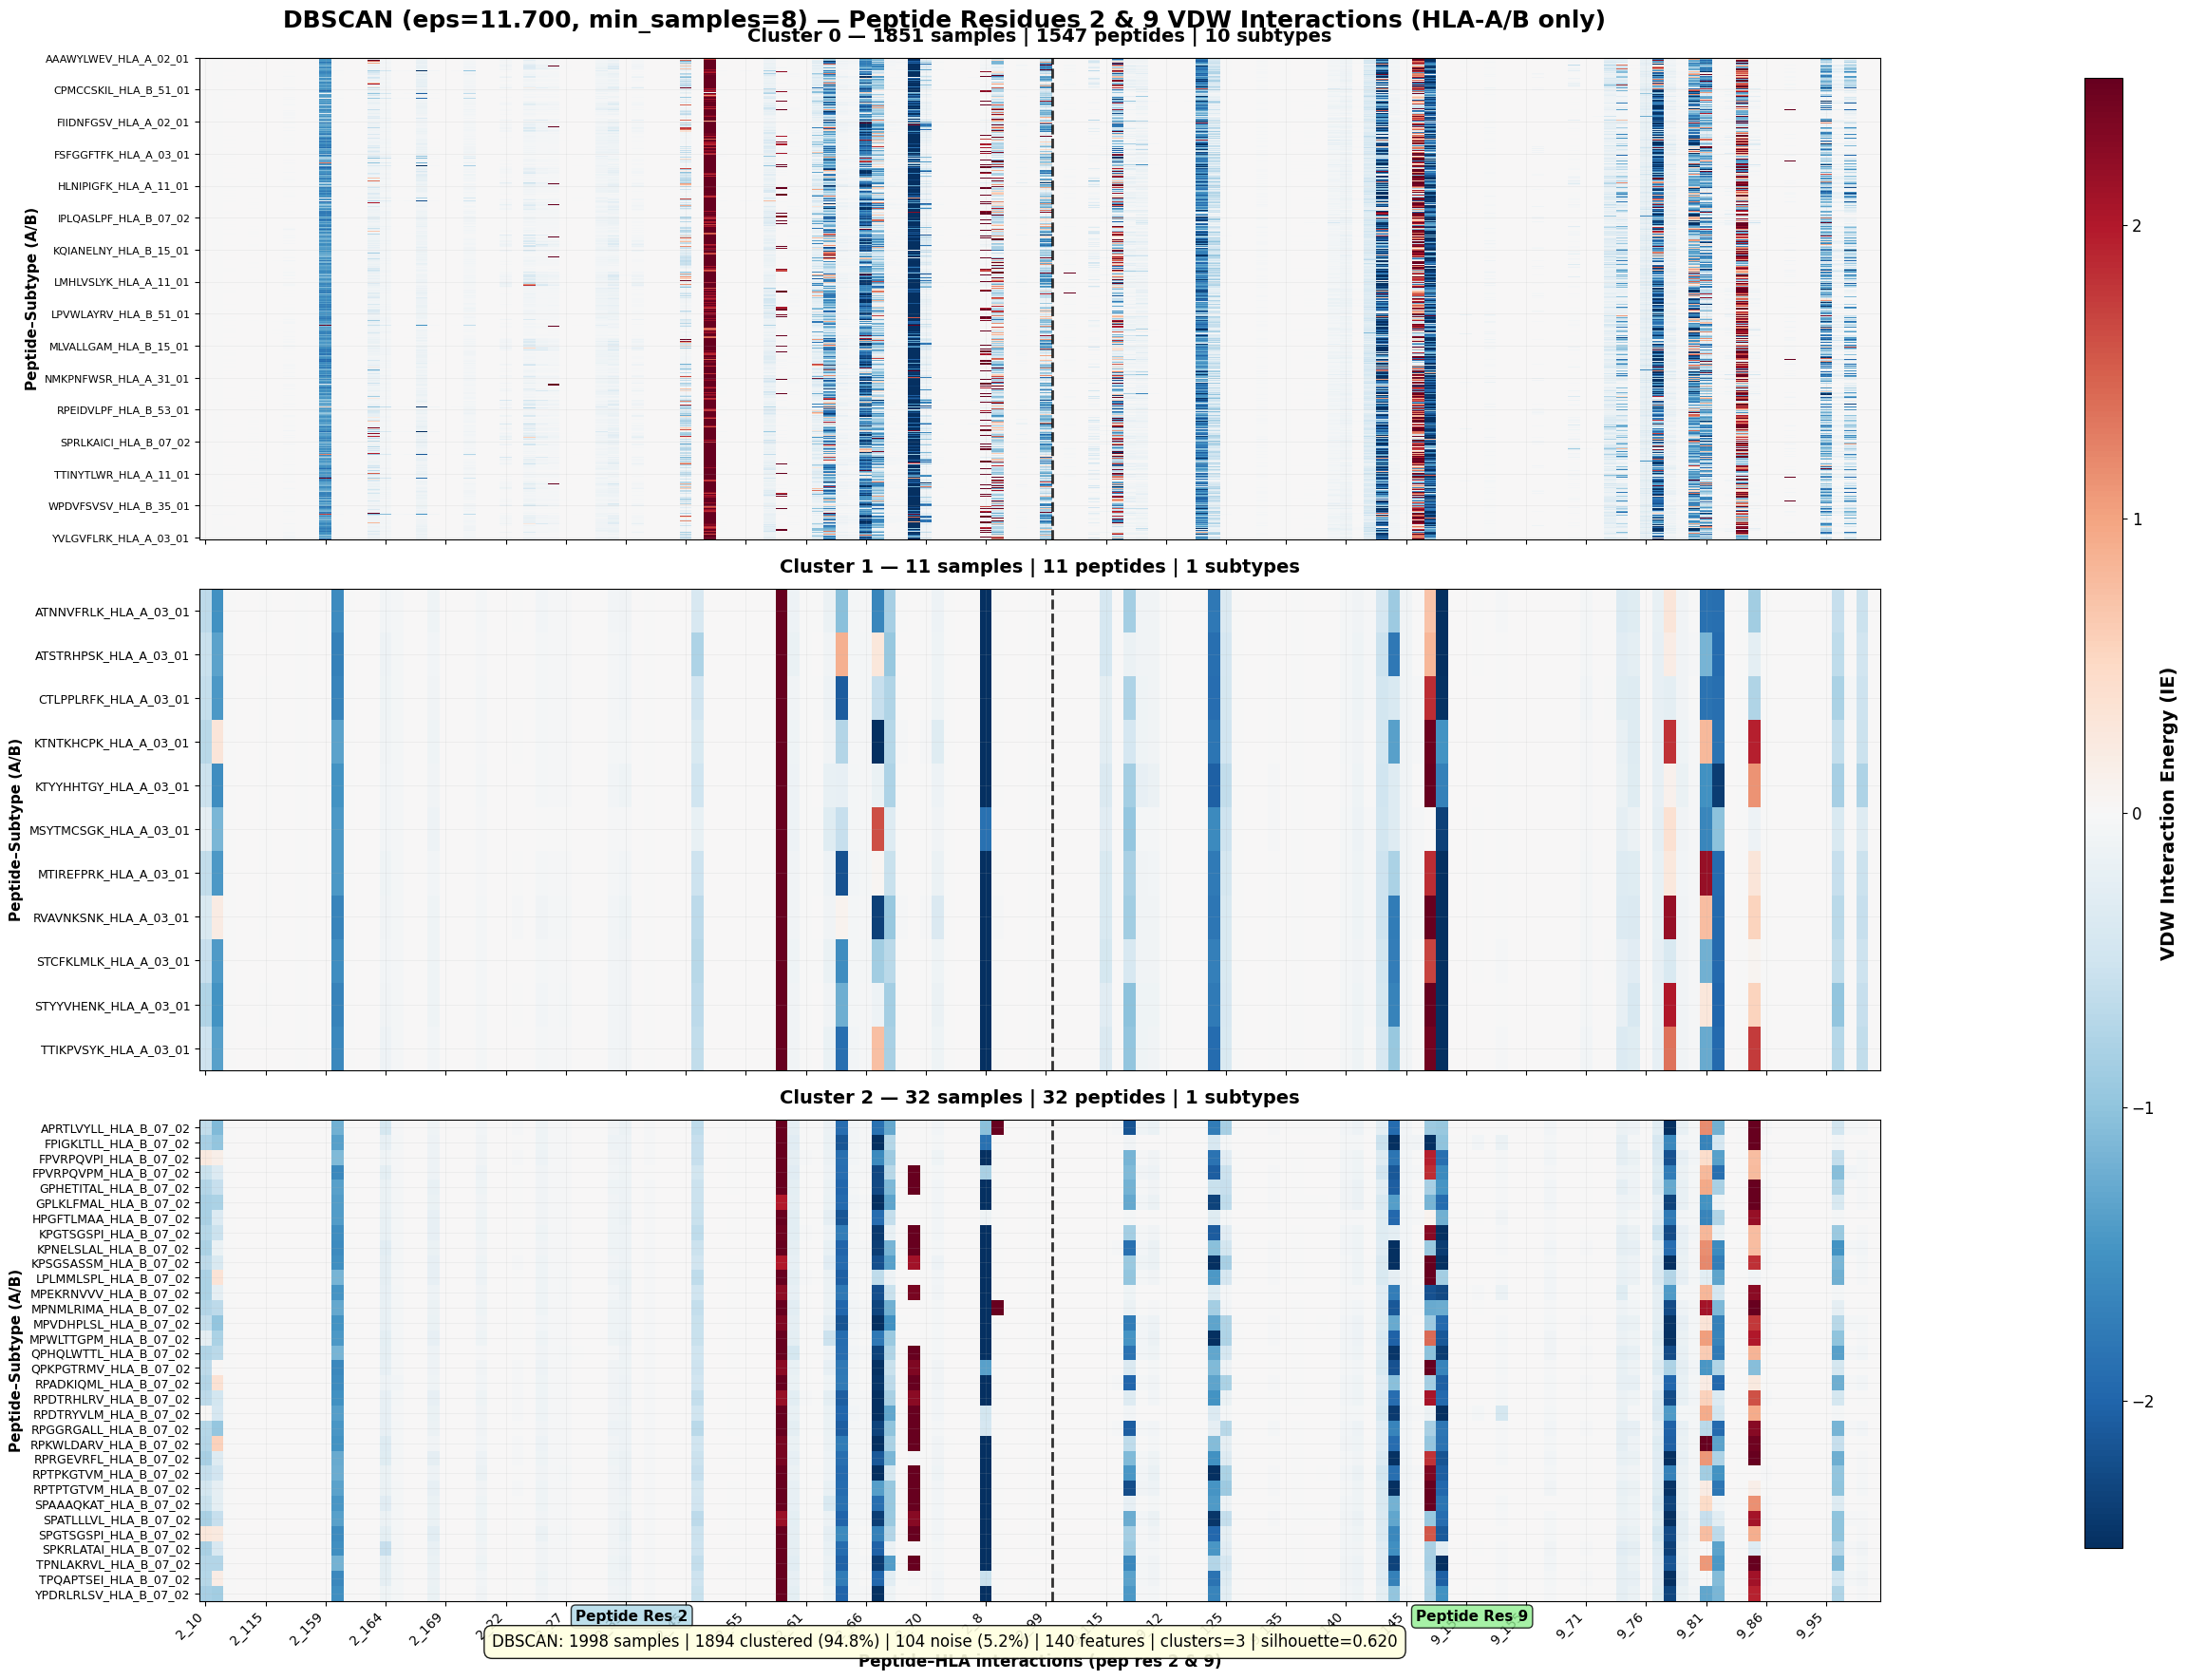


Picking 5 models per cluster

=== Selected 5 per cluster → total 15 candidates ===
            tag  cluster   peptide     subtype  mean_vdw  DOPE  silhouette  dist_to_centroid  distinct_score
    best_energy        0 MMLVPLITV HLA_A_02_01   -0.2123   NaN      0.6026            8.0167          1.1130
       boundary        0 YIYTRSFQM HLA_A_02_01   -0.0225   NaN      0.2839           21.7429         -1.7004
 cluster_medoid        0 FTNPLFYHK HLA_A_31_01   -0.1059   NaN      0.7019            3.3091          1.1986
    distinctive        0 LMDENTYAM HLA_B_35_01   -0.0223   NaN      0.6068            8.2701          2.3858
high_silhouette        0 EPLAVIASL HLA_B_35_01   -0.1365   NaN      0.7031            3.4106          1.3107
    best_energy        1 ATNNVFRLK HLA_A_03_01   -0.1463   NaN      0.5415            5.8210         23.0046
       boundary        1 MSYTMCSGK HLA_A_03_01   -0.0905   NaN      0.3228           10.8838         17.2565
 cluster_medoid        1 MTIREFPRK HLA_A_03_

In [8]:
# =============================================================================
# DBSCAN clustering targeting exactly 3 clusters (A/B subtypes, VDW, pep 2&9)
# + Per-cluster model picking: 5 models per cluster for simulations
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples
import tqdm
import re

plt.style.use('default')
sns.set_palette("husl")

# ----------------------------- Parameters -------------------------------------
DATA_PATH = '/opt/experiments/pep_hla_dynamics/data_compiled/df_ie_master_vdw.xlsx'
TARGET_K = 3                      # target number of clusters for DBSCAN
MIN_CLUSTER_SIZE = 10             # minimum acceptable cluster size
NOISE_THRESHOLDS = [30.0, 40.0, 50.0, 60.0]  # progressively relax if needed
VMIN_GLOBAL, VMAX_GLOBAL = -2.5, 2.5         # heatmap color scale

# Picking settings
N_PER_CLUSTER = 5                 # number of models to pick per cluster
DOPE_CSV_PATH = None              # optional: '/path/to/dope.csv' with columns [peptide, subtype, DOPE]

# --------------------------- Load & basic filters -----------------------------
# IE column is assumed to be van der Waals (VDW) interaction energy in this file
df_ie_master = pd.read_excel(DATA_PATH)

# Keep only HLA-A and HLA-B subtypes
df_ie_master = df_ie_master[df_ie_master['subtype'].str.startswith(('HLA_A', 'HLA_B'))].copy()

# Keep peptide–HLA interactions (C–A or A–C), where C=peptide and A=HLA
peptide_hla = df_ie_master[
    ((df_ie_master['res1_chid'] == 'C') & (df_ie_master['res2_chid'] == 'A')) |
    ((df_ie_master['res1_chid'] == 'A') & (df_ie_master['res2_chid'] == 'C'))
].copy()

# ------------------------ Standardize interaction rows ------------------------
def standardize_interaction(row):
    """Ensure peptide residue info comes first and HLA residue info second."""
    if row['res1_chid'] == 'C':  # peptide on the left
        return {
            'peptide_resnum': row['res1_resnum'],
            'hla_resnum': row['res2_resnum'],
            'peptide_index': row['res1_index'],
            'hla_index': row['res2_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }
    else:  # peptide on the right
        return {
            'peptide_resnum': row['res2_resnum'],
            'hla_resnum': row['res1_resnum'],
            'peptide_index': row['res2_index'],
            'hla_index': row['res1_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }

std_rows = [standardize_interaction(r) for _, r in tqdm.tqdm(
    peptide_hla.iterrows(), total=len(peptide_hla), desc="Standardizing A/B interactions"
)]
df_std = pd.DataFrame(std_rows)

# ------------------- Build feature vectors per (peptide, subtype) -------------
def create_feature_vector(group):
    """Create a 1D IE vector sorted by (peptide_resnum, hla_resnum) with 'pep_hla' ids."""
    g = group.sort_values(['peptide_resnum', 'hla_resnum']).copy()
    g['interaction_id'] = g['peptide_resnum'].astype(str) + '_' + g['hla_resnum'].astype(str)
    return pd.Series(g['IE'].values, index=g['interaction_id'])

feature_vectors = df_std.groupby(['peptide', 'subtype']).apply(create_feature_vector)
clustering_matrix = feature_vectors.unstack(level=-1).fillna(0)

# Keep index meta (MultiIndex: (peptide, subtype))
sample_info = pd.DataFrame(clustering_matrix.index.tolist(), columns=['peptide', 'subtype'])
sample_info.index = clustering_matrix.index

# ----------------- Restrict to peptide residues 2 & 9 + scale -----------------
residues_2_9_cols = [c for c in clustering_matrix.columns if c.split('_')[0] in ('2', '9')]
X_29 = clustering_matrix[residues_2_9_cols].copy()

scaler = StandardScaler()
X_29_scaled = scaler.fit_transform(X_29)

# ---------------------- Partition evaluation helpers --------------------------
def eval_partition(labels: np.ndarray):
    """Compute harmonized stats for a DBSCAN label vector (-1 denotes noise)."""
    n = len(labels)
    n_noise = int((labels == -1).sum())
    labs = [l for l in set(labels) if l != -1]
    n_clusters = len(labs)
    sizes = [int((labels == lab).sum()) for lab in labs]
    min_size = min(sizes) if sizes else 0
    clustered = n - n_noise
    noise_pct = 100.0 * n_noise / n
    return dict(n_clusters=n_clusters, sizes=sizes, min_size=min_size,
                n_noise=n_noise, noise_pct=noise_pct, clustered=clustered)

def k_distance_seed(X_scaled, k_nn):
    """Seed an eps guess from the k-distance elbow; returns eps0."""
    nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X_scaled)
    dists, _ = nbrs.kneighbors(X_scaled)
    d_sorted = np.sort(dists[:, k_nn-1])[::-1]
    grad = np.gradient(d_sorted)
    offset = min(50, max(0, len(grad)//10))
    elbow_idx = np.argmax(grad[offset:]) + offset if len(grad) > 0 else 0
    eps0 = float(d_sorted[elbow_idx]) if len(d_sorted) > 0 else 0.5
    return eps0

# ---------------------- DBSCAN grid search (target K=3) -----------------------
print("\n" + "="*80)
print("DBSCAN grid search targeting exactly 3 clusters")

# Seed eps via k-distance elbow (use at least 5-NN for smoother curve)
k_nn = max(5, MIN_CLUSTER_SIZE)
eps0 = k_distance_seed(X_29_scaled, k_nn=k_nn)

# Build a generous parameter grid around eps0
eps_grid = np.linspace(eps0*0.15, eps0*3.0, 50)
min_samples_grid = [6, 8, 10, 12, 15, 18, 20]

best_candidates_3 = []

for noise_max_pct in NOISE_THRESHOLDS:
    for eps in eps_grid:
        for ms in min_samples_grid:
            labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_29_scaled)
            stats = eval_partition(labels)
            # keep exact-3 candidates that satisfy robustness constraints
            if stats['n_clusters'] == TARGET_K and stats['min_size'] >= MIN_CLUSTER_SIZE and stats['noise_pct'] <= noise_max_pct:
                mask = (labels != -1)
                if mask.sum() > 1 and len(set(labels[mask])) >= 2:
                    sil = silhouette_score(X_29_scaled[mask], labels[mask], metric='euclidean')
                else:
                    sil = -1.0
                best_candidates_3.append({
                    'eps': eps, 'min_samples': ms, 'silhouette': sil,
                    **stats, 'labels': labels, 'noise_limit': noise_max_pct
                })
    if len(best_candidates_3) > 0:
        break  # we already have exact-3 candidates at this noise level

# If we found exact-3, pick by highest silhouette; else pick closest-to-3 (2 or 4)
picked = None
mode = "exact-3"
if len(best_candidates_3) > 0:
    exact3_df = pd.DataFrame([{
        'eps': c['eps'], 'min_samples': c['min_samples'], 'silhouette': c['silhouette'],
        'min_size': c['min_size'], 'noise_pct': c['noise_pct'], 'noise_limit': c['noise_limit']
    } for c in best_candidates_3]).sort_values('silhouette', ascending=False)
    print("\nTop exact-3 DBSCAN candidates (by silhouette):")
    print(exact3_df.head(10).to_string(index=False, float_format=lambda x: f"{x:.3f}"))
    picked = max(best_candidates_3, key=lambda d: d['silhouette'])
else:
    mode = "closest-to-3"
    alt_candidates = []
    for eps in eps_grid:
        for ms in min_samples_grid:
            labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_29_scaled)
            stats = eval_partition(labels)
            if stats['n_clusters'] in (2, 4) and stats['min_size'] >= max(6, MIN_CLUSTER_SIZE//2):
                mask = (labels != -1)
                if mask.sum() > 1 and len(set(labels[mask])) >= 2:
                    sil = silhouette_score(X_29_scaled[mask], labels[mask], metric='euclidean')
                else:
                    sil = -1.0
                alt_candidates.append({
                    'eps': eps, 'min_samples': ms, 'silhouette': sil,
                    **stats, 'labels': labels
                })
    if len(alt_candidates) == 0:
        raise RuntimeError("DBSCAN could not produce multi-cluster solutions. Consider relaxing the grid or features.")
    # choose by (distance to 3, then -silhouette)
    alt_candidates.sort(key=lambda d: (abs(d['n_clusters']-3), -d['silhouette']))
    alt_df = pd.DataFrame([{
        'eps': c['eps'], 'min_samples': c['min_samples'], 'silhouette': c['silhouette'],
        'n_clusters': c['n_clusters'], 'min_size': c['min_size'], 'noise_pct': c['noise_pct']
    } for c in alt_candidates]).head(10)
    print("\nClosest-to-3 DBSCAN candidates (best few):")
    print(alt_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
    picked = alt_candidates[0]

labels = picked['labels']
print("\n=== DBSCAN selection ===")
print(f"Mode: {mode}")
print(f"eps={picked['eps']:.4f} | min_samples={picked['min_samples']} | "
      f"clusters={picked['n_clusters']} | min_size={picked['min_size']} | "
      f"noise={picked['noise_pct']:.1f}% | silhouette={picked['silhouette']:.3f}")

# ------------------------- Plot stacked heatmaps ------------------------------
sample_info_db = sample_info.copy()
sample_info_db['cluster'] = labels

# Exclude noise samples from visualization/picking
valid_mask = (sample_info_db['cluster'] != -1)
sample_info_valid = sample_info_db[valid_mask]
labels_valid = sample_info_valid['cluster'].values

unique = sorted(list(set(labels_valid)))
cluster_info = [(cid, int((labels_valid == cid).sum())) for cid in unique]

n_clusters = len(cluster_info)
fig_h = max(16, 6*n_clusters)
fig, axes = plt.subplots(n_clusters, 1, figsize=(20, fig_h))
if n_clusters == 1:
    axes = [axes]

title_method = f"DBSCAN (eps={picked['eps']:.3f}, min_samples={picked['min_samples']})"
fig.suptitle(f'{title_method} — Peptide Residues 2 & 9 VDW Interactions (HLA-A/B only)',
             fontsize=18, fontweight='bold', y=0.98)

# Precompute residue-2 and residue-9 feature groups for labeling
res2 = [c for c in residues_2_9_cols if c.startswith('2_')]
res9 = [c for c in residues_2_9_cols if c.startswith('9_')]

cluster_mats = []
for i, (cid, csize) in enumerate(cluster_info):
    ax = axes[i]
    cmeta = sample_info_valid[sample_info_valid['cluster'] == cid]
    cmatrix = X_29.loc[cmeta.index]
    cluster_mats.append(cmatrix)

    im = ax.imshow(cmatrix.values, cmap='RdBu_r', aspect='auto',
                   vmin=VMIN_GLOBAL, vmax=VMAX_GLOBAL, interpolation='nearest')

    ax.set_title(f'Cluster {cid} — {csize} samples | '
                 f'{cmeta.peptide.nunique()} peptides | {cmeta.subtype.nunique()} subtypes',
                 fontsize=14, fontweight='bold', pad=12)

    # X ticks and separator between residue-2 and residue-9 features
    nfeat = len(residues_2_9_cols)
    step_x = max(1, nfeat // 25)
    x_pos = range(0, nfeat, step_x)
    x_labs = [residues_2_9_cols[p] for p in x_pos]
    ax.set_xticks(x_pos)
    if i == n_clusters - 1:
        ax.set_xticklabels(x_labs, rotation=45, ha='right', fontsize=10)
        ax.set_xlabel('Peptide–HLA interactions (pep res 2 & 9)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels([])

    if len(res2) > 0 and len(res9) > 0:
        ax.axvline(x=len(res2) - 0.5, color='black', linestyle='--', linewidth=2, alpha=0.8)
        if i == n_clusters - 1:
            ax.text(len(res2)/2, csize + max(1, int(csize*0.02)), 'Peptide Res 2',
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
            ax.text(len(res2)+len(res9)/2, csize + max(1, int(csize*0.02)), 'Peptide Res 9',
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

    # Y ticks (downsample labels for large clusters)
    ylabels = [f"{r.peptide}_{r.subtype}" for _, r in cmeta.iterrows()]
    if csize <= 25:
        ax.set_yticks(range(csize))
        ax.set_yticklabels([s if len(s)<=30 else s[:30]+'…' for s in ylabels], fontsize=9)
    elif csize <= 100:
        step_y = max(1, csize // 20)
        pos = range(0, csize, step_y)
        ax.set_yticks(pos)
        ax.set_yticklabels([ylabels[j] if len(ylabels[j])<=30 else ylabels[j][:30]+'…' for j in pos], fontsize=9)
    else:
        step_y = max(1, csize // 15)
        pos = range(0, csize, step_y)
        ax.set_yticks(pos)
        ax.set_yticklabels([ylabels[j] if len(ylabels[j])<=25 else ylabels[j][:25]+'…' for j in pos], fontsize=8)

    ax.set_ylabel('Peptide–Subtype (A/B)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2, linewidth=0.5)

# Shared colorbar and overall stats line
plt.subplots_adjust(right=0.88, top=0.94, bottom=0.08, hspace=0.3)
cax = fig.add_axes([1.1, 0.08, 0.02, 0.86])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('VDW Interaction Energy (IE)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

n_total = len(sample_info_db)
n_noise = int((sample_info_db['cluster'] == -1).sum())
n_clustered = n_total - n_noise
stats = (f"DBSCAN: {n_total} samples | {n_clustered} clustered ({100*n_clustered/n_total:.1f}%) | "
         f"{n_noise} noise ({100*n_noise/n_total:.1f}%) | {len(residues_2_9_cols)} features | "
         f"clusters={picked['n_clusters']} | silhouette={picked['silhouette']:.3f}")
fig.text(0.5, 0.02, stats, ha='center', va='bottom', fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

# ---------------------- 8) Pick N models per cluster --------------------------
print("\n" + "="*80)
print(f"Picking {N_PER_CLUSTER} models per cluster")

# Align scaled/unscaled matrices to valid (non-noise) subset
X_scaled_df = pd.DataFrame(X_29_scaled, index=X_29.index)
X_unscaled_v = X_29.loc[sample_info_valid.index]
X_scaled_v   = X_scaled_df.loc[sample_info_valid.index].values
clusters_v   = labels_valid

# Per-sample metrics
mean_vdw = X_unscaled_v.mean(axis=1)

# Silhouette per sample (only if >=2 clusters)
try:
    sil_samples = silhouette_samples(X_scaled_v, clusters_v, metric='euclidean')
except Exception:
    sil_samples = np.full(len(clusters_v), np.nan)

# Distance to cluster centroid and distinctiveness vector
dist_to_centroid = np.zeros(len(clusters_v), dtype=float)
distinct_scores  = np.zeros(len(clusters_v), dtype=float)
X_scaled_v_df    = pd.DataFrame(X_scaled_v, index=X_unscaled_v.index)

for cid in np.unique(clusters_v):
    mask_in  = (clusters_v == cid)
    C = X_scaled_v_df[mask_in].mean(axis=0).values
    dist_to_centroid[mask_in] = np.linalg.norm(X_scaled_v[mask_in] - C, axis=1)
    mask_out = ~mask_in
    if mask_out.sum() > 0:
        v = C - X_scaled_v_df[mask_out].mean(axis=0).values
        vn = np.linalg.norm(v)
        if vn > 0:
            v = v / vn
            distinct_scores[mask_in] = (X_scaled_v[mask_in] @ v)

# Optional DOPE merge
dope = pd.Series(np.nan, index=X_unscaled_v.index)
if DOPE_CSV_PATH:
    try:
        df_dope = pd.read_csv(DOPE_CSV_PATH)
        pep_col = next((c for c in df_dope.columns if c.lower()=='peptide'), None)
        sub_col = next((c for c in df_dope.columns if c.lower()=='subtype'), None)
        d_col   = next((c for c in df_dope.columns if c.lower()=='dope'), None)
        if pep_col and sub_col and d_col:
            tmp = df_dope[[pep_col, sub_col, d_col]].copy()
            tmp.columns = ['peptide','subtype','DOPE']
            dope = X_unscaled_v.index.to_series().map(tmp.set_index(['peptide','subtype'])['DOPE'])
        else:
            print("[WARN] DOPE columns not found; skipping DOPE merge.")
    except Exception as e:
        print(f"[WARN] Could not read DOPE file: {e}")

# Build meta table (index = (peptide, subtype))
meta = sample_info_valid.copy()
meta['mean_vdw']         = mean_vdw.values
meta['silhouette']       = sil_samples
meta['dist_to_centroid'] = dist_to_centroid
meta['distinct_score']   = distinct_scores
meta['DOPE']             = dope.values

def _take_next(g, col, ascending=True, used=None):
    """Pick first index from g sorted by column (ignores NaNs), not in 'used'."""
    used = used or set()
    s = g[col].copy()
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        return None
    order = s.sort_values(ascending=ascending).index
    for idx in order:
        if idx not in used:
            return idx
    return None

records = []
for cid, g in meta.groupby('cluster', sort=True):
    used, picks = set(), []

    # 1) Cluster medoid (closest to centroid)
    idx = _take_next(g, 'dist_to_centroid', ascending=True, used=used)
    if idx is not None: used.add(idx); picks.append(('cluster_medoid', idx))

    # 2) Best energy (lowest mean VDW)
    idx = _take_next(g, 'mean_vdw', ascending=True, used=used)
    if idx is not None: used.add(idx); picks.append(('best_energy', idx))

    # 3) Boundary (lowest silhouette) → fallback = farthest from centroid
    idx = _take_next(g, 'silhouette', ascending=True, used=used)
    if idx is None: idx = _take_next(g, 'dist_to_centroid', ascending=False, used=used)
    if idx is not None: used.add(idx); picks.append(('boundary', idx))

    # 4) Most distinctive (largest projection)
    idx = _take_next(g, 'distinct_score', ascending=False, used=used)
    if idx is not None: used.add(idx); picks.append(('distinctive', idx))

    # 5) High-silhouette (well embedded) OR lowest DOPE if available
    if meta['DOPE'].notna().any():
        idx = _take_next(g, 'DOPE', ascending=True, used=used)
        tag5 = 'lowest_dope'
        if idx is None:
            idx = _take_next(g, 'silhouette', ascending=False, used=used)
            tag5 = 'high_silhouette'
    else:
        idx = _take_next(g, 'silhouette', ascending=False, used=used)
        tag5 = 'high_silhouette'
    if idx is None:
        idx = _take_next(g, 'dist_to_centroid', ascending=True, used=used)
        tag5 = 'central_next'
    if idx is not None: used.add(idx); picks.append((tag5, idx))

    # Backfill to exactly N_PER_CLUSTER if the cluster is large enough
    if len(picks) < N_PER_CLUSTER and len(g) > len(picks):
        rest = g.drop(index=list(used)).sort_values(['distinct_score','silhouette'], ascending=[False, False])
        for idx in rest.index[:(N_PER_CLUSTER - len(picks))]:
            used.add(idx); picks.append(('distinctive_next', idx))

    # Materialize rows
    for tag, idx in picks[:min(N_PER_CLUSTER, len(g))]:
        row = meta.loc[idx]; pep, sub = idx
        records.append({
            'tag': tag,
            'cluster': int(cid),
            'peptide': pep,
            'subtype': sub,
            'mean_vdw': float(row['mean_vdw']),
            'DOPE': (np.nan if pd.isna(row['DOPE']) else float(row['DOPE'])),
            'silhouette': (np.nan if not np.isfinite(row['silhouette']) else float(row['silhouette'])),
            'dist_to_centroid': float(row['dist_to_centroid']),
            'distinct_score': float(row['distinct_score']),
        })

picked_df = pd.DataFrame(records, columns=[
    'tag','cluster','peptide','subtype','mean_vdw','DOPE','silhouette','dist_to_centroid','distinct_score'
]).sort_values(['cluster','tag']).reset_index(drop=True)

print(f"\n=== Selected {N_PER_CLUSTER} per cluster → total {len(picked_df)} candidates ===")
print(picked_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x,float) else str(x)))

# Save selection to CSV for traceability
method_clean = f"DBSCAN_eps{picked['eps']:.3f}_ms{picked['min_samples']}"
method_clean = re.sub(r'[^A-Za-z0-9_()+-]+', '_', method_clean)
out_csv = f"simulation_candidates_perCluster{N_PER_CLUSTER}_{method_clean}_k{n_clusters}.csv"
picked_df.to_csv(out_csv, index=False)
print(f"[OK] Saved -> {out_csv}")


STEP 0) Load & filter: A/B subtypes only, VDW only, peptide–HLA pairs
Rows after A/B & pep-HLA filtering: 483,464


Standardizing: 100%|██████████| 483464/483464 [00:14<00:00, 33699.40it/s]


Samples: 1,998 | Features (pep 2&9 only): 140

STEP 1) DBSCAN grid search (min cluster size ≥ 10, noise ≤ 30%)
DBSCAN could not produce ≥2 valid clusters with constraints; will try centroid/graph-based methods.

STEP 2) Multi-method search (K=2..8). Criterion: silhouette (higher) & min size ≥ 10

Top candidates by silhouette:
                       method  k  silhouette  min_size  noise_pct
          Agglomerative(Ward)  2       0.641       113      0.000
                       KMeans  2       0.641       113      0.000
                          GMM  2       0.641       113      0.000
                          GMM  3       0.349       109      0.000
Agglomerative(Average+Cosine)  2       0.155       180      0.000
Agglomerative(Average+Cosine)  4       0.153        71      0.000
Agglomerative(Average+Cosine)  3       0.152       180      0.000
                          GMM  5       0.079        20      0.000

Selected: Agglomerative(Ward) with k=2, silhouette=0.641, min cluster size=11

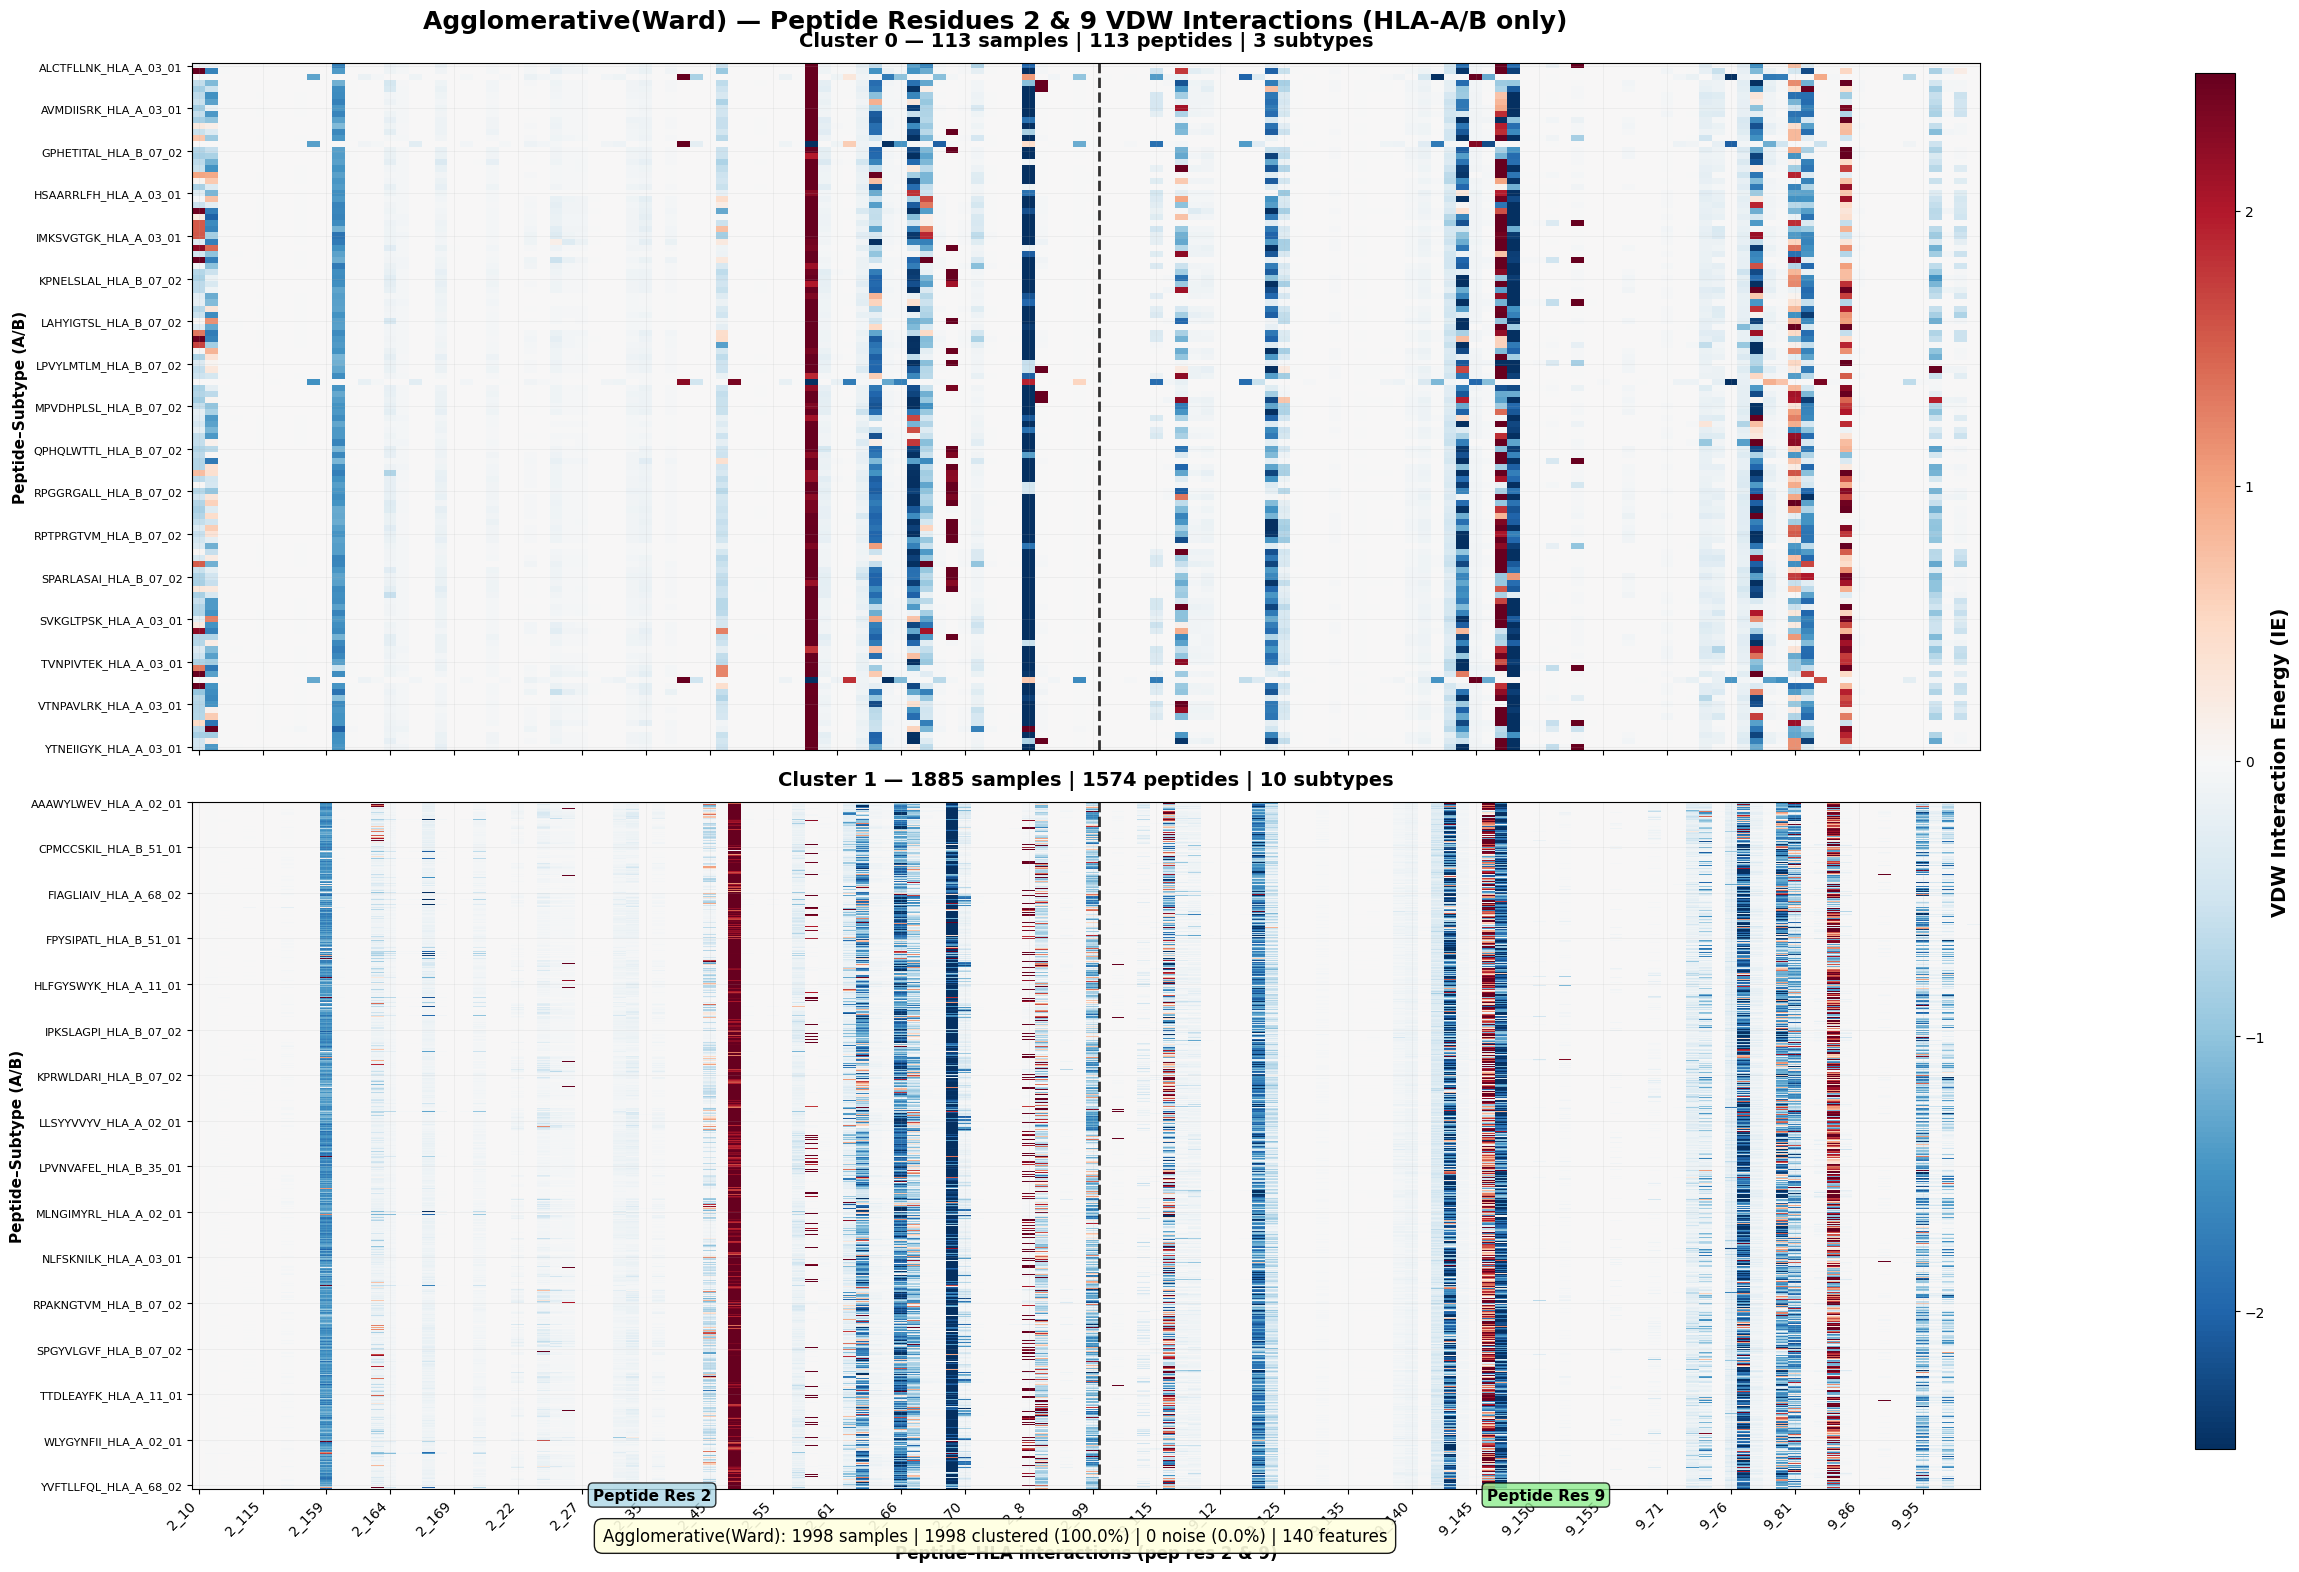


VERTICAL STACK COMPARISON SUMMARY (distinctive interactions)

Cluster 0: size=113 | peptides=113 | subtypes=3 | mean=-0.094 | std=0.713
  Top distinctive interactions:
    • Pep2-HLA5: mean=0.021 (Δ=3.566)
    • Pep9-HLA147: mean=1.491 (Δ=3.427)
    • Pep2-HLA8: mean=-2.630 (Δ=3.234)

Cluster 1: size=1885 | peptides=1574 | subtypes=10 | mean=-0.106 | std=0.707
  Top distinctive interactions:
    • Pep2-HLA5: mean=3.587 (Δ=3.566)
    • Pep9-HLA147: mean=-1.937 (Δ=3.427)
    • Pep2-HLA8: mean=0.604 (Δ=3.234)

STEP 5) Picking 5 models per cluster

=== Selected 5 per cluster → total 10 candidates ===
            tag  cluster   peptide     subtype  mean_vdw  DOPE  silhouette  dist_to_centroid  distinct_score
    best_energy        0 MPVDHPLSL HLA_B_07_02   -0.1785   NaN      0.1174           15.1708         24.0426
       boundary        0 MSYSMCTGK HLA_A_03_01   -0.0438   NaN     -0.2766           14.6287         12.1343
 cluster_medoid        0 YPDRLRLSV HLA_B_07_02   -0.1594   NaN     -

In [9]:
# ============================================================
# A/B ONLY + VDW ONLY → Multi-Method Clustering (Pep 2 & 9)
# Produces: Method sweep → best partition → stacked heatmaps + text summary
# + Picks 5 models per cluster for simulations
# ============================================================
import pandas as pd, numpy as np, tqdm, warnings, sys, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings("ignore")
plt.style.use('default'); sns.set_palette("husl")

# --------------------------- I/O & picking params ----------------------------
print("="*80)
print("STEP 0) Load & filter: A/B subtypes only, VDW only, peptide–HLA pairs")
DATA_PATH = '/opt/experiments/pep_hla_dynamics/data_compiled/df_ie_master_vdw.xlsx'
DOPE_CSV_PATH = None   # e.g. '/path/to/dope_scores.csv' with [peptide, subtype, DOPE]
N_PER_CLUSTER = 5      # pick 5 models per cluster

df = pd.read_excel(DATA_PATH)

# ---- only HLA-A and HLA-B
df = df[df['subtype'].str.startswith(('HLA_A','HLA_B'))].copy()

# ---- only peptide–HLA interactions (C–A or A–C; C=peptide, A=HLA)
df = df[
    ((df['res1_chid']=='C') & (df['res2_chid']=='A')) |
    ((df['res1_chid']=='A') & (df['res2_chid']=='C'))
].copy()
print(f"Rows after A/B & pep-HLA filtering: {len(df):,}")

# --------------------- Standardization ---------------------------------------
def _std(r):
    """Place peptide residue columns first (consistent feature ordering)."""
    if r['res1_chid']=='C':
        return {'peptide_resnum':r['res1_resnum'], 'hla_resnum':r['res2_resnum'],
                'peptide_index':r['res1_index'], 'hla_index':r['res2_index'],
                'IE':r['IE'], 'subtype':r['subtype'], 'peptide':r['peptide']}
    else:
        return {'peptide_resnum':r['res2_resnum'], 'hla_resnum':r['res1_resnum'],
                'peptide_index':r['res2_index'], 'hla_index':r['res1_index'],
                'IE':r['IE'], 'subtype':r['subtype'], 'peptide':r['peptide']}

std_rows = [ _std(r) for _,r in tqdm.tqdm(df.iterrows(), total=len(df), desc="Standardizing") ]
d = pd.DataFrame(std_rows)

# --------------- Feature vectors per (peptide, subtype) -----------------------
def _feat(g):
    """Return 1D IE vector sorted by (peptide_resnum, hla_resnum)."""
    g = g.sort_values(['peptide_resnum','hla_resnum']).copy()
    g['interaction_id'] = g['peptide_resnum'].astype(str)+'_'+g['hla_resnum'].astype(str)
    return pd.Series(g['IE'].values, index=g['interaction_id'])

fv = d.groupby(['peptide','subtype']).apply(_feat)
X_all = fv.unstack(-1).fillna(0)

sample_info = pd.DataFrame(X_all.index.tolist(), columns=['peptide','subtype'])
sample_info.index = X_all.index

# ---- restrict to peptide residues 2 & 9
cols_29 = [c for c in X_all.columns if c.split('_')[0] in ('2','9')]
X29 = X_all[cols_29].copy()
print(f"Samples: {X29.shape[0]:,} | Features (pep 2&9 only): {X29.shape[1]}")

# ---- scaled matrix for algorithms (plots use unscaled values)
scaler = StandardScaler()
X29_scaled = scaler.fit_transform(X29)

# ------------------- Helper: eval partition ----------------------------------
def eval_partition(labels: np.ndarray):
    """Return cluster stats (noise as -1 for DBSCAN) with harmonized keys."""
    n = len(labels)
    n_noise = int((labels == -1).sum()) if isinstance(labels, np.ndarray) else 0
    labs = [l for l in set(labels) if l != -1]
    n_clusters = len(labs)
    sizes = [int((labels == lab).sum()) for lab in labs]
    min_size = min(sizes) if sizes else 0
    clustered = n - n_noise
    noise_pct = 100.0 * n_noise / n
    return dict(n_clusters=n_clusters, sizes=sizes, min_size=min_size,
                n_noise=n_noise, noise_pct=noise_pct, clustered=clustered)

# ============================================================
# STEP 1) DBSCAN grid search (density-based)
# ============================================================
print("\n" + "="*80)
print("STEP 1) DBSCAN grid search (min cluster size ≥ 10, noise ≤ 30%)")
min_cluster_size_req = 10
noise_max_pct = 30.0

# k-distance elbow for eps seed
k_nn = min_cluster_size_req
nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X29_scaled)
dists, _ = nbrs.kneighbors(X29_scaled)
d_sorted = np.sort(dists[:, k_nn-1])[::-1]
grad = np.gradient(d_sorted)
offset = min(50, max(0, len(grad)//10))
elbow_idx = np.argmax(grad[offset:]) + offset if len(grad) > 0 else 0
eps0 = float(d_sorted[elbow_idx]) if len(d_sorted)>0 else 0.5

eps_grid = np.linspace(eps0*0.3, eps0*2.0, 30)
min_samples_grid = [8,10,12,15]

best_db = None; best_db_score = -1e9
for eps in eps_grid:
    for ms in min_samples_grid:
        lbl = DBSCAN(eps=eps, min_samples=ms).fit_predict(X29_scaled)
        stats = eval_partition(lbl)
        valid = (stats['n_clusters']>=2 and stats['min_size']>=min_cluster_size_req and stats['noise_pct']<=noise_max_pct)
        score = -1e6
        if valid:
            score = stats['clustered'] - stats['noise_pct'] + min(stats['n_clusters']*5, 25)
        if score > best_db_score:
            best_db_score = score
            best_db = dict(eps=eps, min_samples=ms, labels=lbl, **stats)

if best_db and best_db['n_clusters']>=2:
    print(f"DBSCAN found {best_db['n_clusters']} clusters | min size {best_db['min_size']} | noise {best_db['noise_pct']:.1f}%")
else:
    print("DBSCAN could not produce ≥2 valid clusters with constraints; will try centroid/graph-based methods.")

# ============================================================
# STEP 2) Multi-method sweep (Agglomerative, KMeans, GMM) K=2..8
# ============================================================
print("\n" + "="*80)
print("STEP 2) Multi-method search (K=2..8). Criterion: silhouette (higher) & min size ≥ 10")

def try_agglomerative(X, k, linkage='ward', metric='euclidean'):
    """Compatibility across sklearn versions; ward requires euclidean."""
    try:
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=metric)
    except TypeError:
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage, affinity=metric)
    return model.fit_predict(X)

def try_kmeans(X, k, random_state=0):
    return KMeans(n_clusters=k, n_init=20, random_state=random_state).fit_predict(X)

def try_gmm(X, k, random_state=0):
    return GaussianMixture(n_components=k, covariance_type='full', n_init=5, random_state=random_state).fit_predict(X)

candidates = []
K_range = range(2, 9)
for k in K_range:
    # Agglomerative (Ward/Euclidean)
    lbl = try_agglomerative(X29_scaled, k, linkage='ward', metric='euclidean')
    stats = eval_partition(lbl)
    if stats['min_size']>=min_cluster_size_req:
        sil = silhouette_score(X29_scaled, lbl, metric='euclidean')
        candidates.append({'method':'Agglomerative(Ward)', 'k':k, 'silhouette':sil, **stats, 'labels':lbl})

    # Agglomerative (Average/Cosine)
    lbl = try_agglomerative(X29_scaled, k, linkage='average', metric='cosine')
    stats = eval_partition(lbl)
    if stats['min_size']>=min_cluster_size_req:
        sil = silhouette_score(X29_scaled, lbl, metric='cosine')
        candidates.append({'method':'Agglomerative(Average+Cosine)', 'k':k, 'silhouette':sil, **stats, 'labels':lbl})

    # KMeans
    lbl = try_kmeans(X29_scaled, k)
    stats = eval_partition(lbl)
    if stats['min_size']>=min_cluster_size_req:
        sil = silhouette_score(X29_scaled, lbl, metric='euclidean')
        candidates.append({'method':'KMeans', 'k':k, 'silhouette':sil, **stats, 'labels':lbl})

    # GMM
    lbl = try_gmm(X29_scaled, k)
    stats = eval_partition(lbl)
    if stats['min_size']>=min_cluster_size_req:
        sil = silhouette_score(X29_scaled, lbl, metric='euclidean')
        candidates.append({'method':'GMM', 'k':k, 'silhouette':sil, **stats, 'labels':lbl})

# Include DBSCAN as a candidate (silhouette over non-noise)
if best_db and best_db['n_clusters']>=2:
    mask = (best_db['labels'] != -1)
    sil_db = silhouette_score(X29_scaled[mask], best_db['labels'][mask], metric='euclidean') \
             if mask.sum() >= 2 and len(set(best_db['labels'][mask])) >= 2 else -1.0
    candidates.append({
        'method': f"DBSCAN(eps={best_db['eps']:.3f},ms={best_db['min_samples']})",
        'k': best_db['n_clusters'],
        'silhouette': sil_db,
        **{k_: best_db[k_] for k_ in ['n_clusters','min_size','n_noise','noise_pct','clustered']},
        'labels': best_db['labels']
    })

if len(candidates)==0:
    print("No valid clustering with current constraints; falling back to Agglomerative(Ward, k=2).")
    lbl = try_agglomerative(X29_scaled, 2, linkage='ward', metric='euclidean')
    stats = eval_partition(lbl)
    sil = silhouette_score(X29_scaled, lbl, metric='euclidean')
    candidates.append({'method':'Agglomerative(Ward)', 'k':2, 'silhouette':sil, **stats, 'labels':lbl})

cand_df = pd.DataFrame([{
    'method': c['method'], 'k': c['k'], 'silhouette': c['silhouette'],
    'min_size': c['min_size'], 'noise_pct': c.get('noise_pct', 0.0)
} for c in candidates]).sort_values('silhouette', ascending=False)

print("\nTop candidates by silhouette:")
print(cand_df.head(8).to_string(index=False, float_format=lambda x: f"{x:.3f}"))

best = max(candidates, key=lambda c: c['silhouette'])
final_labels = best['labels']
final_method, final_k = best['method'], best['k']
print(f"\nSelected: {final_method} with k={final_k}, silhouette={best['silhouette']:.3f}, min cluster size={best['min_size']}")

# ============================================================
# STEP 3) Final stacked heatmaps + descriptive text
# ============================================================
print("\n" + "="*80)
print("STEP 3) Plot vertically stacked heatmaps for final clusters")

sample_info_final = sample_info.copy()
sample_info_final['cluster'] = final_labels

# Drop noise if method is DBSCAN
valid_mask = sample_info_final['cluster'] != -1 if -1 in sample_info_final['cluster'].values else np.ones(len(sample_info_final), dtype=bool)
sample_info_valid = sample_info_final[valid_mask]
labels_valid = sample_info_valid['cluster'].values
clusters_sorted = sorted([c for c in set(labels_valid)])

# Collect matrices for each cluster
cluster_info = [(cid, int((labels_valid==cid).sum())) for cid in clusters_sorted]
n_clusters = len(cluster_info)
fig_h = max(16, 6*n_clusters)
fig, axes = plt.subplots(n_clusters, 1, figsize=(20, fig_h))
if n_clusters==1: axes=[axes]
fig.suptitle(f'{final_method} — Peptide Residues 2 & 9 VDW Interactions (HLA-A/B only)', fontsize=18, fontweight='bold', y=0.98)

vmin_global, vmax_global = -2.5, 2.5
cluster_mats = []

res2 = [c for c in cols_29 if c.startswith('2_')]
res9 = [c for c in cols_29 if c.startswith('9_')]

for i, (cid, csize) in enumerate(cluster_info):
    ax = axes[i]
    cmeta = sample_info_valid[sample_info_valid['cluster']==cid]
    cm = X29.loc[cmeta.index]
    cluster_mats.append(cm)

    im = ax.imshow(cm.values, cmap='RdBu_r', aspect='auto', vmin=vmin_global, vmax=vmax_global, interpolation='nearest')
    ax.set_title(f'Cluster {cid} — {csize} samples | {cmeta.peptide.nunique()} peptides | {cmeta.subtype.nunique()} subtypes',
                 fontsize=14, fontweight='bold', pad=12)

    # x labels & separator
    nfeat = len(cols_29); step_x = max(1, nfeat//25); x_pos = range(0, nfeat, step_x)
    ax.set_xticks(x_pos)
    if i==n_clusters-1:
        ax.set_xticklabels([cols_29[p] for p in x_pos], rotation=45, ha='right', fontsize=10)
        ax.set_xlabel('Peptide–HLA interactions (pep res 2 & 9)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels([])

    if len(res2)>0 and len(res9)>0:
        ax.axvline(x=len(res2)-0.5, color='black', linestyle='--', linewidth=2, alpha=0.8)
        if i==n_clusters-1:
            ax.text(len(res2)/2, csize + max(1,int(csize*0.02)), 'Peptide Res 2', ha='center', va='bottom',
                    fontsize=11, fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
            ax.text(len(res2)+len(res9)/2, csize + max(1,int(csize*0.02)), 'Peptide Res 9', ha='center', va='bottom',
                    fontsize=11, fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

    # y labels
    ylabels = [f"{r.peptide}_{r.subtype}" for _, r in cmeta.iterrows()]
    if csize <= 25:
        ax.set_yticks(range(csize)); ax.set_yticklabels([s if len(s)<=30 else s[:30]+'…' for s in ylabels], fontsize=9)
    elif csize <= 100:
        step_y = max(1, csize//20); pos = range(0, csize, step_y)
        ax.set_yticks(pos); ax.set_yticklabels([ylabels[j] if len(ylabels[j])<=30 else ylabels[j][:30]+'…' for j in pos], fontsize=9)
    else:
        step_y = max(1, csize//15); pos = range(0, csize, step_y)
        ax.set_yticks(pos); ax.set_yticklabels([ylabels[j] if len(ylabels[j])<=25 else ylabels[j][:25]+'…' for j in pos], fontsize=8)

    ax.set_ylabel('Peptide–Subtype (A/B)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2, linewidth=0.5)

# shared colorbar
plt.subplots_adjust(right=0.88, top=0.94, bottom=0.08, hspace=0.30)
cax = fig.add_axes([1.1, 0.08, 0.02, 0.86])
cbar = fig.colorbar(im, cax=cax); cbar.set_label('VDW Interaction Energy (IE)', fontsize=14, fontweight='bold')

# global stats
n_total = len(sample_info_final)
n_noise = int((sample_info_final['cluster']==-1).sum()) if -1 in sample_info_final['cluster'].values else 0
n_clustered = n_total - n_noise
fig.text(0.5, 0.02, f"{final_method}: {n_total} samples | {n_clustered} clustered ({100*n_clustered/n_total:.1f}%) | {n_noise} noise ({100*n_noise/n_total:.1f}%) | {len(cols_29)} features",
         ha='center', va='bottom', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9))

plt.tight_layout(); plt.show()

# ============================================================
# STEP 4) Text summary: distinctive interactions per cluster
# ============================================================
print("\n" + "="*80)
print("VERTICAL STACK COMPARISON SUMMARY (distinctive interactions)")
for i, (cid, csize) in enumerate(cluster_info):
    cm = cluster_mats[i]
    cmeta = sample_info_valid[sample_info_valid['cluster']==cid]
    mean_energy = cm.values.mean(); std_energy = cm.values.std()
    print(f"\nCluster {cid}: size={csize} | peptides={cmeta.peptide.nunique()} | subtypes={cmeta.subtype.nunique()} | mean={mean_energy:.3f} | std={std_energy:.3f}")

    if len(cluster_mats)>1:
        others = [cluster_mats[j] for j in range(len(cluster_mats)) if j!=i]
        current_means = cm.mean()
        other_means = pd.concat([m.mean() for m in others], axis=1).mean(axis=1)
        diffs = (current_means - other_means).abs().sort_values(ascending=False).head(3)
        print("  Top distinctive interactions:")
        for feat, diff in diffs.items():
            pep_res, hla_res = feat.split('_'); cur = current_means[feat]
            print(f"    • Pep{pep_res}-HLA{hla_res}: mean={cur:.3f} (Δ={diff:.3f})")

# ============================================================
# STEP 5) Pick 5 models per cluster (simulation candidates)
# ============================================================
print("\n" + "="*80)
print(f"STEP 5) Picking {N_PER_CLUSTER} models per cluster")

# Build aligned matrices (valid = non-noise)
X_scaled_df = pd.DataFrame(X29_scaled, index=X29.index)
X_unscaled_v = X29.loc[sample_info_valid.index]
X_scaled_v   = X_scaled_df.loc[sample_info_valid.index].values
clusters_v   = labels_valid

# Per-sample metrics
mean_vdw = X_unscaled_v.mean(axis=1)

# Silhouette per sample (on scaled features, Euclidean)
try:
    sil_samples = silhouette_samples(X_scaled_v, clusters_v, metric='euclidean')
except Exception:
    sil_samples = np.full(len(clusters_v), np.nan)

# Distance to centroid (scaled space) + distinctiveness projection
dist_to_centroid = np.zeros(len(clusters_v), dtype=float)
distinct_scores  = np.zeros(len(clusters_v), dtype=float)
X_scaled_v_df    = pd.DataFrame(X_scaled_v, index=X_unscaled_v.index)

for cid in np.unique(clusters_v):
    mask_in  = (clusters_v == cid)
    C = X_scaled_v_df[mask_in].mean(axis=0).values
    dist_to_centroid[mask_in] = np.linalg.norm(X_scaled_v[mask_in] - C, axis=1)
    mask_out = ~mask_in
    if mask_out.sum() > 0:
        v = C - X_scaled_v_df[mask_out].mean(axis=0).values
        vn = np.linalg.norm(v)
        if vn > 0:
            v = v / vn
            distinct_scores[mask_in] = (X_scaled_v[mask_in] @ v)

# Optional DOPE merge
dope = pd.Series(np.nan, index=X_unscaled_v.index)
if DOPE_CSV_PATH:
    try:
        df_dope = pd.read_csv(DOPE_CSV_PATH)
        pep_col = next((c for c in df_dope.columns if c.lower()=='peptide'), None)
        sub_col = next((c for c in df_dope.columns if c.lower()=='subtype'), None)
        d_col   = next((c for c in df_dope.columns if c.lower()=='dope'), None)
        if pep_col and sub_col and d_col:
            tmp = df_dope[[pep_col, sub_col, d_col]].copy()
            tmp.columns = ['peptide','subtype','DOPE']
            dope = X_unscaled_v.index.to_series().map(tmp.set_index(['peptide','subtype'])['DOPE'])
        else:
            print("[WARN] DOPE columns not found; skipping DOPE merge.")
    except Exception as e:
        print(f"[WARN] Could not read DOPE file: {e}")

# Build meta table (index = (peptide, subtype))
meta = sample_info_valid.copy()
meta['mean_vdw']         = mean_vdw.values
meta['silhouette']       = sil_samples
meta['dist_to_centroid'] = dist_to_centroid
meta['distinct_score']   = distinct_scores
meta['DOPE']             = dope.values

def _take_next(g, col, ascending=True, used=None):
    """Pick first index from g sorted by column (ignores NaNs), not in 'used'."""
    used = used or set()
    s = g[col].copy().replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        return None
    order = s.sort_values(ascending=ascending).index
    for idx in order:
        if idx not in used:
            return idx
    return None

records = []
for cid, g in meta.groupby('cluster', sort=True):
    used, picks = set(), []

    # 1) Cluster medoid (closest to centroid)
    idx = _take_next(g, 'dist_to_centroid', ascending=True, used=used)
    if idx is not None: used.add(idx); picks.append(('cluster_medoid', idx))

    # 2) Best energy (lowest mean VDW)
    idx = _take_next(g, 'mean_vdw', ascending=True, used=used)
    if idx is not None: used.add(idx); picks.append(('best_energy', idx))

    # 3) Boundary (lowest silhouette) → fallback = farthest from centroid
    idx = _take_next(g, 'silhouette', ascending=True, used=used)
    if idx is None: idx = _take_next(g, 'dist_to_centroid', ascending=False, used=used)
    if idx is not None: used.add(idx); picks.append(('boundary', idx))

    # 4) Most distinctive (largest projection)
    idx = _take_next(g, 'distinct_score', ascending=False, used=used)
    if idx is not None: used.add(idx); picks.append(('distinctive', idx))

    # 5) High-silhouette OR lowest DOPE if available → fallback = next central
    if meta['DOPE'].notna().any():
        idx = _take_next(g, 'DOPE', ascending=True, used=used)
        tag5 = 'lowest_dope'
        if idx is None:
            idx = _take_next(g, 'silhouette', ascending=False, used=used)
            tag5 = 'high_silhouette'
    else:
        idx = _take_next(g, 'silhouette', ascending=False, used=used)
        tag5 = 'high_silhouette'
    if idx is None:
        idx = _take_next(g, 'dist_to_centroid', ascending=True, used=used)
        tag5 = 'central_next'
    if idx is not None: used.add(idx); picks.append((tag5, idx))

    # Backfill to exactly N_PER_CLUSTER if more are needed
    if len(picks) < N_PER_CLUSTER and len(g) > len(picks):
        rest = g.drop(index=list(used)).sort_values(['distinct_score','silhouette'], ascending=[False, False])
        for idx in rest.index[:(N_PER_CLUSTER - len(picks))]:
            used.add(idx); picks.append(('distinctive_next', idx))

    # Materialize rows
    for tag, idx in picks[:min(N_PER_CLUSTER, len(g))]:
        row = meta.loc[idx]; pep, sub = idx
        records.append({
            'tag': tag,
            'cluster': int(cid),
            'peptide': pep,
            'subtype': sub,
            'mean_vdw': float(row['mean_vdw']),
            'DOPE': (np.nan if pd.isna(row['DOPE']) else float(row['DOPE'])),
            'silhouette': (np.nan if not np.isfinite(row['silhouette']) else float(row['silhouette'])),
            'dist_to_centroid': float(row['dist_to_centroid']),
            'distinct_score': float(row['distinct_score']),
        })

picked_df = pd.DataFrame(records, columns=[
    'tag','cluster','peptide','subtype','mean_vdw','DOPE','silhouette','dist_to_centroid','distinct_score'
]).sort_values(['cluster','tag']).reset_index(drop=True)

print(f"\n=== Selected {N_PER_CLUSTER} per cluster → total {len(picked_df)} candidates ===")
print(picked_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x,float) else str(x)))

# Save selection to CSV
method_clean = re.sub(r'[^A-Za-z0-9_()+-]+', '_', str(final_method))
out_csv = f"simulation_candidates_perCluster{N_PER_CLUSTER}_{method_clean}_k{len(clusters_sorted)}.csv"
picked_df.to_csv(out_csv, index=False)
print(f"[OK] Saved -> {out_csv}")


Standardizing A/B interactions: 100%|██████████| 483464/483464 [00:14<00:00, 32803.96it/s]



K-Means candidates (sorted by silhouette):
 k  silhouette    inertia      ch    db  min_size
 2       0.641 230780.162 423.277 1.404       113

Selected K → K=2 (silhouette=0.641, elbow=0.000, CH=423.3, DB=1.404)


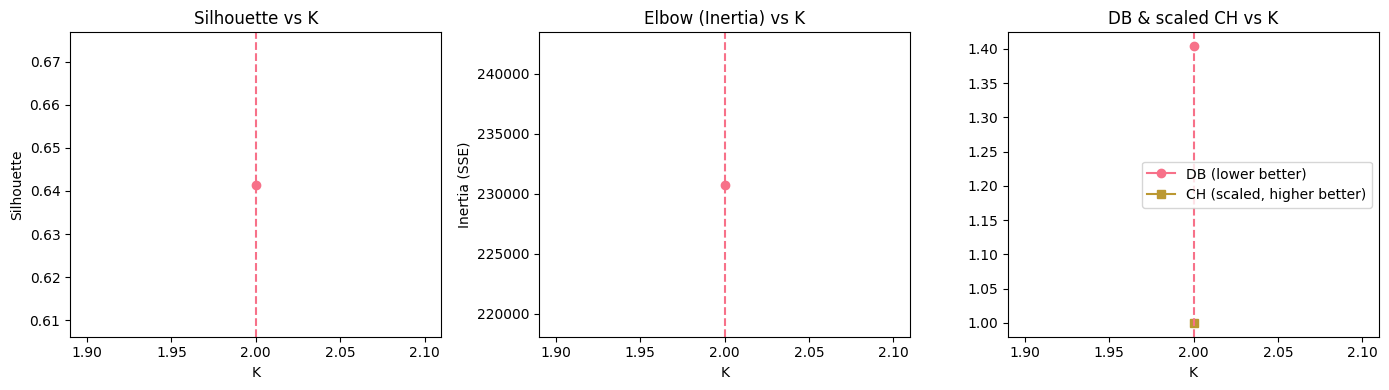

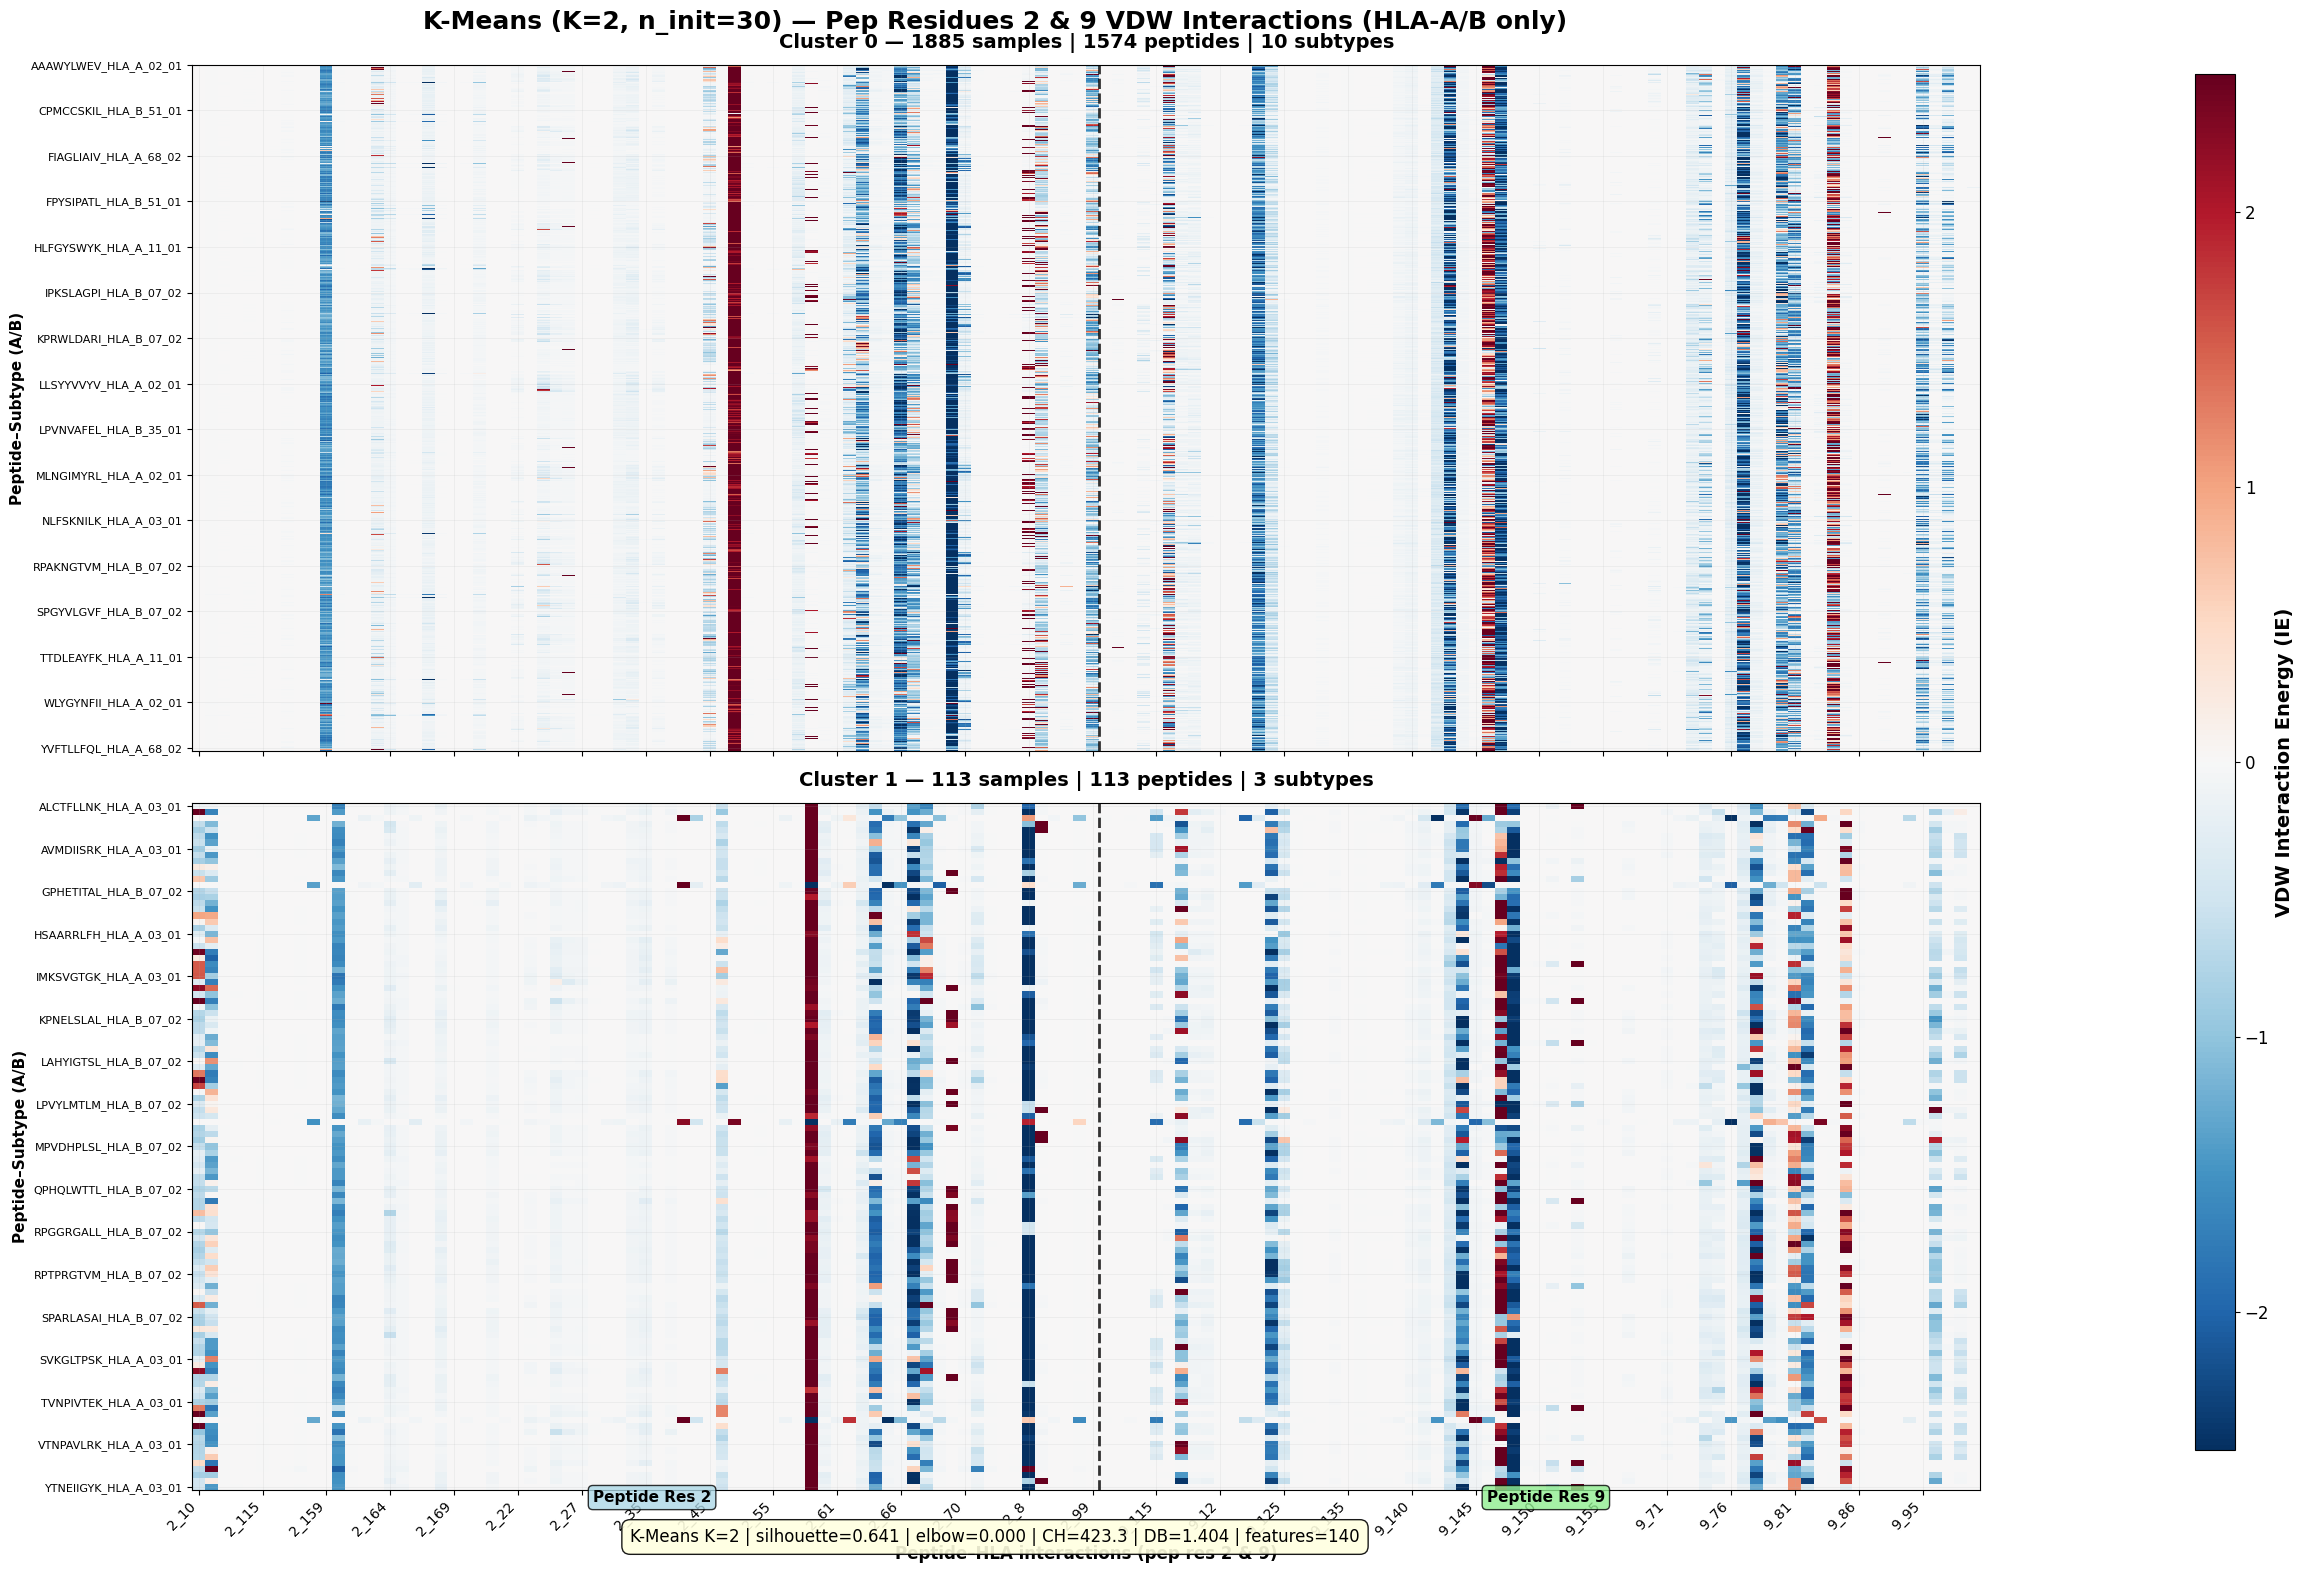


STEP 5) Picking 5 models per cluster for simulations

=== Selected 5 per cluster → total 10 candidates ===
            tag  cluster   peptide     subtype  mean_vdw  DOPE  silhouette  dist_to_centroid  distinct_score
    best_energy        0 MMLVPLITV HLA_A_02_01   -0.2123   NaN      0.6669            8.0284          1.0989
       boundary        0 MTTTANWLW HLA_B_53_01   -0.0045   NaN      0.1338           57.3444          1.7408
 cluster_medoid        0 FTNPLFYHK HLA_A_31_01   -0.1059   NaN      0.7498            3.3336          1.3083
    distinctive        0 WFYDNDNPY HLA_B_35_01    0.0444   NaN      0.3779           24.7599          2.5377
high_silhouette        0 EPLAVIASL HLA_B_35_01   -0.1365   NaN      0.7504            3.4335          1.3943
    best_energy        1 MPVDHPLSL HLA_B_07_02   -0.1785   NaN      0.1174           15.1708         24.0426
       boundary        1 MSYSMCTGK HLA_A_03_01   -0.0438   NaN     -0.2766           14.6287         12.1343
 cluster_medoid     

In [10]:
# =============================================================================
# K-Means clustering with model selection (A/B subtypes, VDW, pep residues 2&9)
# - Loads VDW-only table
# - Keeps HLA-A/B and peptide–HLA (C–A or A–C) rows
# - Standardizes to have peptide first, HLA second
# - Builds (peptide, subtype) feature vectors; keeps residues 2 & 9 only
# - Scales features; runs K-Means for K=2..8
# - Computes silhouette, inertia (elbow), Calinski-Harabasz, Davies-Bouldin
# - Enforces min cluster size; picks best K by silhouette (tie-break by elbow/CH/DB)
# - Plots stacked heatmaps for the selected partition
# - SELECTS 5 MODELS PER CLUSTER for simulations (CSV output)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    calinski_harabasz_score, davies_bouldin_score
)
import tqdm
import re

plt.style.use('default')
sns.set_palette("husl")

# ----------------------------- Parameters -------------------------------------
DATA_PATH = '/opt/experiments/pep_hla_dynamics/data_compiled/df_ie_master_vdw.xlsx'
K_RANGE = range(2, 9)       # candidate K values (2..8)
MIN_CLUSTER_SIZE = 10       # minimum acceptable cluster size
N_INIT = 30                 # multiple random initializations for robustness
MAX_ITER = 500              # allow enough iterations to converge
RANDOM_STATE = 42           # reproducibility
VMIN_GLOBAL, VMAX_GLOBAL = -2.5, 2.5  # heatmap color scale
FORCE_K3 = False            # set True to force K=3 (skip model selection)

# Optional DOPE CSV with columns [peptide, subtype, DOPE]; leave None to skip
DOPE_CSV_PATH = None
N_PER_CLUSTER = 5           # pick 5 models per cluster

# --------------------------- Load & basic filters -----------------------------
# IE is assumed to be van der Waals (VDW) interaction energy in this file
df_ie_master = pd.read_excel(DATA_PATH)

# Keep only HLA-A and HLA-B subtypes
df_ie_master = df_ie_master[df_ie_master['subtype'].str.startswith(('HLA_A', 'HLA_B'))].copy()

# Keep peptide–HLA interactions (C–A or A–C), where C=peptide and A=HLA
peptide_hla = df_ie_master[
    ((df_ie_master['res1_chid'] == 'C') & (df_ie_master['res2_chid'] == 'A')) |
    ((df_ie_master['res1_chid'] == 'A') & (df_ie_master['res2_chid'] == 'C'))
].copy()

# ------------------------ Standardize interaction rows ------------------------
def standardize_interaction(row):
    """Ensure peptide residue info comes first and HLA residue info second."""
    if row['res1_chid'] == 'C':  # peptide on the left
        return {
            'peptide_resnum': row['res1_resnum'],
            'hla_resnum': row['res2_resnum'],
            'peptide_index': row['res1_index'],
            'hla_index': row['res2_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }
    else:  # peptide on the right
        return {
            'peptide_resnum': row['res2_resnum'],
            'hla_resnum': row['res1_resnum'],
            'peptide_index': row['res2_index'],
            'hla_index': row['res1_index'],
            'IE': row['IE'],
            'subtype': row['subtype'],
            'peptide': row['peptide']
        }

std_rows = [standardize_interaction(r) for _, r in tqdm.tqdm(
    peptide_hla.iterrows(), total=len(peptide_hla), desc="Standardizing A/B interactions"
)]
df_std = pd.DataFrame(std_rows)

# ------------------- Build feature vectors per (peptide, subtype) -------------
def create_feature_vector(group):
    """Create a 1D IE vector sorted by (peptide_resnum, hla_resnum) with 'pep_hla' ids."""
    g = group.sort_values(['peptide_resnum', 'hla_resnum']).copy()
    g['interaction_id'] = g['peptide_resnum'].astype(str) + '_' + g['hla_resnum'].astype(str)
    return pd.Series(g['IE'].values, index=g['interaction_id'])

feature_vectors = df_std.groupby(['peptide', 'subtype']).apply(create_feature_vector)
clustering_matrix = feature_vectors.unstack(level=-1).fillna(0)

# Keep index meta (MultiIndex: (peptide, subtype))
sample_info = pd.DataFrame(clustering_matrix.index.tolist(), columns=['peptide', 'subtype'])
sample_info.index = clustering_matrix.index

# ----------------- Restrict to peptide residues 2 & 9 + scale -----------------
residues_2_9_cols = [c for c in clustering_matrix.columns if c.split('_')[0] in ('2', '9')]
X_29 = clustering_matrix[residues_2_9_cols].copy()

scaler = StandardScaler()
X_29_scaled = scaler.fit_transform(X_29)

# ------------------------- Fit & evaluate K-Means -----------------------------
def evaluate_kmeans(X_scaled, k, n_init=10, max_iter=300, random_state=0):
    """Fit KMeans(k) and compute metrics. Returns labels and a metrics dict."""
    km = KMeans(
        n_clusters=k, init='k-means++',
        n_init=n_init if isinstance(n_init, int) else 10,
        max_iter=max_iter, random_state=random_state, verbose=0
    )
    labels = km.fit_predict(X_scaled)

    sizes = [int(np.sum(labels == c)) for c in np.unique(labels)]
    min_size = min(sizes) if sizes else 0
    sil = silhouette_score(X_scaled, labels, metric='euclidean') if len(set(labels)) > 1 else -1.0
    inertia = km.inertia_
    ch = calinski_harabasz_score(X_scaled, labels) if len(set(labels)) > 1 else -np.inf
    db = davies_bouldin_score(X_scaled, labels) if len(set(labels)) > 1 else np.inf

    return labels, dict(silhouette=sil, inertia=inertia, ch=ch, db=db, min_size=min_size)

results = []
if FORCE_K3:
    lbl, m = evaluate_kmeans(X_29_scaled, 3, n_init=N_INIT, max_iter=MAX_ITER, random_state=RANDOM_STATE)
    if m['min_size'] < MIN_CLUSTER_SIZE:
        print("[WARN] K=3 violates min cluster size; consider adjusting MIN_CLUSTER_SIZE or features.")
    results.append(dict(k=3, labels=lbl, **m))
else:
    for k in K_RANGE:
        lbl, m = evaluate_kmeans(X_29_scaled, k, n_init=N_INIT, max_iter=MAX_ITER, random_state=RANDOM_STATE)
        if m['min_size'] >= MIN_CLUSTER_SIZE:
            results.append(dict(k=k, labels=lbl, **m))

if len(results) == 0:
    raise RuntimeError("No K satisfied the minimum cluster size constraint. "
                       "Try reducing MIN_CLUSTER_SIZE or expand K_RANGE.")

# ------------------------- Select the best K ----------------------------------
res_df = pd.DataFrame([{k:v for k,v in r.items() if k!='labels'} for r in results]).sort_values('silhouette', ascending=False)
print("\nK-Means candidates (sorted by silhouette):")
print(res_df[['k','silhouette','inertia','ch','db','min_size']].to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# Elbow helper
res_df = res_df.sort_values('k')
res_df['inertia_prev'] = res_df['inertia'].shift(1)
res_df['inertia_drop'] = (res_df['inertia_prev'] - res_df['inertia']) / res_df['inertia_prev']
res_df['inertia_drop'] = res_df['inertia_drop'].fillna(0)

# Composite rank
res_rank = res_df.copy()
res_rank['r_sil'] = res_rank['silhouette'].rank(ascending=False, method='min')
res_rank['r_drop'] = res_rank['inertia_drop'].rank(ascending=False, method='min')
res_rank['r_ch']  = res_rank['ch'].rank(ascending=False, method='min')
res_rank['r_db']  = res_rank['db'].rank(ascending=True, method='min')  # lower DB better
res_rank['score'] = 0.6*res_rank['r_sil'] + 0.3*res_rank['r_drop'] + 0.1*res_rank['r_ch'] - 0.1*res_rank['r_db']

best_row = res_rank.sort_values(['score','r_sil']).iloc[0]
best_k = int(best_row['k'])
print(f"\nSelected K → K={best_k} "
      f"(silhouette={res_df.loc[res_df['k']==best_k,'silhouette'].values[0]:.3f}, "
      f"elbow={res_df.loc[res_df['k']==best_k,'inertia_drop'].values[0]:.3f}, "
      f"CH={res_df.loc[res_df['k']==best_k,'ch'].values[0]:.1f}, "
      f"DB={res_df.loc[res_df['k']==best_k,'db'].values[0]:.3f})")

labels = next(r['labels'] for r in results if r['k']==best_k)

# ------------------------- Plot metric curves ---------------------------------
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(res_df['k'], res_df['silhouette'], marker='o')
plt.xlabel('K'); plt.ylabel('Silhouette'); plt.title('Silhouette vs K')
plt.axvline(best_k, linestyle='--')

plt.subplot(1,3,2)
plt.plot(res_df['k'], res_df['inertia'], marker='o')
plt.xlabel('K'); plt.ylabel('Inertia (SSE)'); plt.title('Elbow (Inertia) vs K')
plt.axvline(best_k, linestyle='--')

plt.subplot(1,3,3)
plt.plot(res_df['k'], res_df['db'], marker='o', label='DB (lower better)')
plt.plot(res_df['k'], res_df['ch']/res_df['ch'].max(), marker='s', label='CH (scaled, higher better)')
plt.xlabel('K'); plt.title('DB & scaled CH vs K'); plt.legend()
plt.axvline(best_k, linestyle='--')
plt.tight_layout(); plt.show()

# ------------------------- Plot stacked heatmaps ------------------------------
sample_info_km = sample_info.copy()
sample_info_km['cluster'] = labels

unique = sorted(sample_info_km['cluster'].unique())
cluster_info = [(cid, int(np.sum(labels==cid))) for cid in unique]

n_clusters = len(cluster_info)
fig_h = max(16, 6*n_clusters)
fig, axes = plt.subplots(n_clusters, 1, figsize=(20, fig_h))
if n_clusters == 1:
    axes = [axes]

fig.suptitle(f'K-Means (K={best_k}, n_init={N_INIT}) — Pep Residues 2 & 9 VDW Interactions (HLA-A/B only)',
             fontsize=18, fontweight='bold', y=0.98)

# Precompute residue-2 and residue-9 feature groups for labeling
res2 = [c for c in residues_2_9_cols if c.startswith('2_')]
res9 = [c for c in residues_2_9_cols if c.startswith('9_')]

cluster_mats = []
for i, (cid, csize) in enumerate(cluster_info):
    ax = axes[i]
    cmeta = sample_info_km[sample_info_km['cluster'] == cid]
    cmatrix = X_29.loc[cmeta.index]
    cluster_mats.append(cmatrix)

    im = ax.imshow(cmatrix.values, cmap='RdBu_r', aspect='auto',
                   vmin=VMIN_GLOBAL, vmax=VMAX_GLOBAL, interpolation='nearest')

    ax.set_title(f'Cluster {cid} — {csize} samples | '
                 f'{cmeta.peptide.nunique()} peptides | {cmeta.subtype.nunique()} subtypes',
                 fontsize=14, fontweight='bold', pad=12)

    # X ticks and separator between residue-2 and residue-9 features
    nfeat = len(residues_2_9_cols)
    step_x = max(1, nfeat // 25)
    x_pos = range(0, nfeat, step_x)
    x_labs = [residues_2_9_cols[p] for p in x_pos]
    ax.set_xticks(x_pos)
    if i == n_clusters - 1:
        ax.set_xticklabels(x_labs, rotation=45, ha='right', fontsize=10)
        ax.set_xlabel('Peptide–HLA interactions (pep res 2 & 9)', fontsize=12, fontweight='bold')
    else:
        ax.set_xticklabels([])

    if len(res2) > 0 and len(res9) > 0:
        ax.axvline(x=len(res2) - 0.5, color='black', linestyle='--', linewidth=2, alpha=0.8)
        if i == n_clusters - 1:
            ax.text(len(res2)/2, csize + max(1, int(csize*0.02)), 'Peptide Res 2',
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
            ax.text(len(res2)+len(res9)/2, csize + max(1, int(csize*0.02)), 'Peptide Res 9',
                    ha='center', va='bottom', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8))

    # Y ticks (downsample labels for large clusters)
    ylabels = [f"{r.peptide}_{r.subtype}" for _, r in cmeta.iterrows()]
    if csize <= 25:
        ax.set_yticks(range(csize))
        ax.set_yticklabels([s if len(s)<=30 else s[:30]+'…' for s in ylabels], fontsize=9)
    elif csize <= 100:
        step_y = max(1, csize // 20)
        pos = range(0, csize, step_y)
        ax.set_yticks(pos)
        ax.set_yticklabels([ylabels[j] if len(ylabels[j])<=30 else ylabels[j][:30]+'…' for j in pos], fontsize=9)
    else:
        step_y = max(1, csize // 15)
        pos = range(0, csize, step_y)
        ax.set_yticks(pos)
        ax.set_yticklabels([ylabels[j] if len(ylabels[j])<=25 else ylabels[j][:25]+'…' for j in pos], fontsize=8)

    ax.set_ylabel('Peptide–Subtype (A/B)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2, linewidth=0.5)

# Shared colorbar and overall stats line
plt.subplots_adjust(right=0.88, top=0.94, bottom=0.08, hspace=0.3)
cax = fig.add_axes([1.1, 0.08, 0.02, 0.86])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('VDW Interaction Energy (IE)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

sel = res_df.loc[res_df['k']==best_k].iloc[0]
footer = (f"K-Means K={best_k} | silhouette={sel['silhouette']:.3f} | "
          f"elbow={res_df.loc[res_df['k']==best_k,'inertia_drop'].values[0]:.3f} | "
          f"CH={sel['ch']:.1f} | DB={sel['db']:.3f} | features={len(residues_2_9_cols)}")
fig.text(0.5, 0.02, footer, ha='center', va='bottom', fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

# ======================== STEP 5: Pick 5 models per cluster ===================
print("\n" + "="*80)
print(f"STEP 5) Picking {N_PER_CLUSTER} models per cluster for simulations")

# Aligned matrices / arrays
X_scaled_df = pd.DataFrame(X_29_scaled, index=X_29.index)
clusters = sample_info_km['cluster'].values

# Per-sample metrics
mean_vdw = X_29.mean(axis=1)  # average VDW energy across features
sil_samples = silhouette_samples(X_29_scaled, clusters, metric='euclidean') if len(np.unique(clusters))>1 else np.full(len(clusters), np.nan)

# Distance to centroid (scaled space) and distinctiveness projection
dist_to_centroid = np.zeros(len(clusters), dtype=float)
distinct_scores  = np.zeros(len(clusters), dtype=float)

X_scaled_df['cluster'] = clusters
for cid in np.unique(clusters):
    in_mask  = (clusters == cid)
    out_mask = ~in_mask
    C = X_scaled_df.loc[in_mask, X_scaled_df.columns[:-1]].mean(axis=0).values
    dist_to_centroid[in_mask] = np.linalg.norm(X_29_scaled[in_mask] - C, axis=1)
    if out_mask.sum() > 0:
        v = C - X_scaled_df.loc[out_mask, X_scaled_df.columns[:-1]].mean(axis=0).values
        vn = np.linalg.norm(v)
        if vn > 0:
            v = v / vn
            distinct_scores[in_mask] = (X_29_scaled[in_mask] @ v)

# Optional DOPE merge
dope = pd.Series(np.nan, index=X_29.index)
if DOPE_CSV_PATH:
    try:
        df_dope = pd.read_csv(DOPE_CSV_PATH)
        pep_col = next((c for c in df_dope.columns if c.lower()=='peptide'), None)
        sub_col = next((c for c in df_dope.columns if c.lower()=='subtype'), None)
        d_col   = next((c for c in df_dope.columns if c.lower()=='dope'), None)
        if pep_col and sub_col and d_col:
            tmp = df_dope[[pep_col, sub_col, d_col]].copy()
            tmp.columns = ['peptide','subtype','DOPE']
            dope = X_29.index.to_series().map(tmp.set_index(['peptide','subtype'])['DOPE'])
        else:
            print("[WARN] DOPE columns not found; skipping DOPE merge.")
    except Exception as e:
        print(f"[WARN] Could not read DOPE file: {e}")

# Build meta table keyed by (peptide, subtype)
meta = sample_info_km.copy()
meta['mean_vdw']         = mean_vdw.values
meta['silhouette']       = sil_samples
meta['dist_to_centroid'] = dist_to_centroid
meta['distinct_score']   = distinct_scores
meta['DOPE']             = dope.values

def _take_next(g, col, ascending=True, used=None):
    """Pick first index from g sorted by column (ignores NaNs), not in 'used'."""
    used = used or set()
    s = g[col].copy().replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
        return None
    order = s.sort_values(ascending=ascending).index
    for idx in order:
        if idx not in used:
            return idx
    return None

records = []
for cid, g in meta.groupby('cluster', sort=True):
    used, picks = set(), []

    # 1) Cluster medoid (closest to centroid)
    idx = _take_next(g, 'dist_to_centroid', ascending=True, used=used)
    if idx is not None: used.add(idx); picks.append(('cluster_medoid', idx))

    # 2) Best energy (lowest mean VDW)
    idx = _take_next(g, 'mean_vdw', ascending=True, used=used)
    if idx is not None: used.add(idx); picks.append(('best_energy', idx))

    # 3) Boundary (lowest silhouette) → fallback: farthest from centroid
    idx = _take_next(g, 'silhouette', ascending=True, used=used)
    if idx is None: idx = _take_next(g, 'dist_to_centroid', ascending=False, used=used)
    if idx is not None: used.add(idx); picks.append(('boundary', idx))

    # 4) Most distinctive (largest projection)
    idx = _take_next(g, 'distinct_score', ascending=False, used=used)
    if idx is not None: used.add(idx); picks.append(('distinctive', idx))

    # 5) High-silhouette OR lowest DOPE if available → fallback: next central
    if meta['DOPE'].notna().any():
        idx = _take_next(g, 'DOPE', ascending=True, used=used); tag5 = 'lowest_dope'
        if idx is None:
            idx = _take_next(g, 'silhouette', ascending=False, used=used); tag5 = 'high_silhouette'
    else:
        idx = _take_next(g, 'silhouette', ascending=False, used=used); tag5 = 'high_silhouette'
    if idx is None:
        idx = _take_next(g, 'dist_to_centroid', ascending=True, used=used); tag5 = 'central_next'
    if idx is not None: used.add(idx); picks.append((tag5, idx))

    # Backfill to exactly N_PER_CLUSTER if more are needed
    if len(picks) < N_PER_CLUSTER and len(g) > len(picks):
        rest = g.drop(index=list(used)).sort_values(['distinct_score','silhouette'], ascending=[False, False])
        for idx in rest.index[:(N_PER_CLUSTER - len(picks))]:
            used.add(idx); picks.append(('distinctive_next', idx))

    # Materialize rows
    for tag, idx in picks[:min(N_PER_CLUSTER, len(g))]:
        row = meta.loc[idx]; pep, sub = idx
        records.append({
            'tag': tag,
            'cluster': int(cid),
            'peptide': pep,
            'subtype': sub,
            'mean_vdw': float(row['mean_vdw']),
            'DOPE': (np.nan if pd.isna(row['DOPE']) else float(row['DOPE'])),
            'silhouette': (np.nan if not np.isfinite(row['silhouette']) else float(row['silhouette'])),
            'dist_to_centroid': float(row['dist_to_centroid']),
            'distinct_score': float(row['distinct_score']),
        })

picked_df = pd.DataFrame(records, columns=[
    'tag','cluster','peptide','subtype','mean_vdw','DOPE','silhouette','dist_to_centroid','distinct_score'
]).sort_values(['cluster','tag']).reset_index(drop=True)

print(f"\n=== Selected {N_PER_CLUSTER} per cluster → total {len(picked_df)} candidates ===")
print(picked_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x,float) else str(x)))

# Save selection to CSV
out_csv = f"simulation_candidates_perCluster{N_PER_CLUSTER}_KMeans_k{best_k}.csv"
picked_df.to_csv(out_csv, index=False)
print(f"[OK] Saved -> {out_csv}")
